`os:` For interacting with the operating system, such as file and directory operations.

`numpy:` Provides support for numerical computations and array manipulations.

`PIL:` Handles image processing tasks like opening and converting images.

`torch:` Core library for creating and training deep learning models with PyTorch.

`shutil:` Facilitates high-level file operations like copying and moving files.

`random:` Used for generating random numbers, helpful for data shuffling and splitting.

`torchvision:` Includes pre-built models, datasets, and image transformations for computer vision.

`matplotlib.pyplot:` Used for creating static, animated, and interactive plots.

`pandas:` Provides data structures and functions for data manipulation and analysis.

`timm:` Provides additional pre-trained models and efficient architectures.

`sklearn.metrics:` Contains tools for evaluating model performance, such as confusion matrix and classification report.

`seaborn:` Extends Matplotlib for more sophisticated data visualizations, like heatmaps.


In [1]:
!pip install kneed

In [2]:
import os
import numpy as np
import pandas as pd
import shutil
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import datasets, transforms, models
import timm
from kneed import KneeLocator
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, ParameterGrid
import matplotlib.pyplot as plt
from PIL import Image
import warnings

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [4]:
# Suppressing warning messages to avoid cluttering the output
warnings.filterwarnings("ignore") 

In [5]:
# Reading the CSV file into a DataFrame for data processing
df = pd.read_csv('/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv')

In [6]:
df.head(2)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   

  Left-Diagnostic Keywords Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                 cataract             normal fundus  0  0  0  1  0  0  0  0   
1            normal fundus             normal fundus  1  0  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg

In [7]:
# Setting the display option to show all rows in the DataFrame when printing
pd.set_option('display.max_rows', None)

# Preprocessing

The images right now are not in a proper labeled format. For futher classification process, the images needs be classified into right labels. 
The below given code is used fo classification of the images into 3 different categories of images 
The images are classified into 3 categories right now is because the eye images are much similar to each other so it will create biased results when classifying the images into different categori.w.

In [9]:
# Defining the custom function for exact keyword matching to specific labels
def map_to_label_exact(keyword):
    if keyword == 'normal fundus':
        return 'Normal Fundus'  
    elif keyword == 'retinopathy':
        return 'Diabetes' 
    elif keyword == 'severe nonproliferative retinopathy':
        return 'Diabetes' 
    elif keyword == 'cataract':
        return 'Cataract'  
    elif keyword == 'moderate non proliferative retinopathy':
        return 'Diabetes'  
#     elif keyword == 'pathological myopia':
#         return 'Pathological Myopia'
#     elif keyword == 'dry age-related macular degeneration':
#         return 'Age-related Macular Degeneration' 
    elif keyword == 'glaucoma':
        return 'Glaucoma'  
    elif keyword == 'drusen':
        return 'Drusen'  
#     elif keyword == 'hypertensive retinopathy':
#         return 'Hypertension' 
    else:
        return 'Other diseases/abnormalities'  

# Applying the custom function to map the 'Right-Diagnostic Keywords' and 'Left-Diagnostic Keywords' columns
df['right_label_column'] = df['Right-Diagnostic Keywords'].apply(map_to_label_exact) 
df['left_label_column'] = df['Left-Diagnostic Keywords'].apply(map_to_label_exact)  

# Creating separate DataFrames for right and left eye diagnostic keywords and labels
df_right = df[['Right-Diagnostic Keywords', 'right_label_column']]  
df_left = df[['Left-Diagnostic Keywords', 'left_label_column']]  


In [10]:
# Concatenating the 'Right-Fundus' image file paths to the 'df_right' DataFrame
df_right = pd.concat([df_right, df[['Right-Fundus']]], axis=1)

# Renaming columns in 'df_right' to more descriptive names
df_right.rename(columns={"right_label_column": "disease", "Right-Fundus": "image_file"}, inplace=True)

# Dropping the original 'Right-Diagnostic Keywords' column from 'df_right' since it's no longer needed
df_right.drop("Right-Diagnostic Keywords", axis=1, inplace=True)

# Concatenating the 'Left-Fundus' image file paths to the 'df_left' DataFrame
df_left = pd.concat([df_left, df[['Left-Fundus']]], axis=1)

# Renaming columns in 'df_left' to more descriptive names
df_left.rename(columns={"left_label_column": "disease", "Left-Fundus": "image_file"}, inplace=True)

# Combining the 'df_right' and 'df_left' DataFrames into a single DataFrame 'df_labeled'
df_labeled = pd.concat([df_right, df_left])

# Dropping the original 'Left-Diagnostic Keywords' column from 'df_labeled' since it's no longer needed
df_labeled.drop("Left-Diagnostic Keywords", axis=1, inplace=True)

# Counting the occurrences of each disease label in the 'disease' column
df_labeled['disease'].value_counts()


disease
Normal Fundus                   5501
Other diseases/abnormalities    4350
Diabetes                        1748
Cataract                         518
Glaucoma                         397
Drusen                           270
Name: count, dtype: int64

There are two types of images in the dataset, the Right eye image and, the Left eye image, the labele attatched to a particular eye image is matched with the diseease keyword if both the keywords are a match then the particular eye image will be given a label of that disease in a new column.


In [11]:
df_labeled.head()

disease   image_file
0                 Normal Fundus  0_right.jpg
1                 Normal Fundus  1_right.jpg
2                      Diabetes  2_right.jpg
3  Other diseases/abnormalities  4_right.jpg
4                      Diabetes  5_right.jpg

As we are proceeding with 3 categories of eye disease classification, the fourthc class `other diseases` which contains all the non classified eye disease images, removing the fourth class to avoid any distraction for the model to understand the patterns among 3 categories of the disease.

In [12]:
# Filtering 'df_labeled' to include only rows where the 'disease' column has values 'Glaucoma', 'Cataract', or 'Diabetes'
df_labeled = df_labeled.loc[(df_labeled['disease'] == 'Glaucoma') | 
                            (df_labeled['disease'] == 'Cataract') | 
                            (df_labeled['disease'] == 'Diabetes')]

The images are classified into categories, now the task is to store the labeled images into their respected disease folder, the `classified_images` folder, which will contain folders of disease containing eye images of the particular disease.

In [13]:
# Creating the main directory 'classified_images/train' and any necessary parent directories if they do not already exist
base_dir = 'classified_images/train'
os.makedirs(base_dir, exist_ok=True)

# Creating subdirectories for each unique label in 'df_labeled'
labels = df_labeled['disease'].unique()
for label in labels:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

# Defining the source directory containing the images
source_dir = '/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/'

# Iterating over each row in 'df_labeled' to copy images to the corresponding folders
for index, row in df_labeled.iterrows():
    source_file = os.path.join(source_dir, row['image_file'])  # Constructing the path to the image in the source directory
    label = row['disease']  # Getting the label for the image
    dest_folder = os.path.join(base_dir, label)  # Defining the destination folder based on the label
    dest_file = os.path.join(dest_folder, row['image_file'])  # Defining the destination path for the image

    # Checking if the source file exists before attempting to copy
    if not os.path.isfile(source_file):
        print(f"File {source_file} does not exist.")
        continue

    # Copying the image file from the source to the destination folder
    shutil.copy2(source_file, dest_file)
#     print(f"Copied {source_file} to {dest_file}")  # Optionally printing the copied file paths


As we have created a new folder for the images classified, we only have the train set for the images, creating a test set for model training is essential.

In [14]:
# Setting the directories for training and testing images
train_dir = './classified_images/train'
test_dir = './classified_images/test'

# Creating the test directory if it does not already exist
os.makedirs(test_dir, exist_ok=True)

# Defining the proportion of the dataset to be used for the test set
test_size = 0.2

# Iterating over each label folder in the training directory
for label_folder in os.listdir(train_dir):
    label_train_dir = os.path.join(train_dir, label_folder)  # Constructing the path to the current label's training folder
    label_test_dir = os.path.join(test_dir, label_folder)  # Constructing the path to the current label's test folder
    
    # Creating the corresponding label folder in the test directory
    os.makedirs(label_test_dir, exist_ok=True)
    
    # Listing all images in the current label folder
    images = os.listdir(label_train_dir)
    
    # Shuffling the list of images to ensure random sampling
    random.shuffle(images)
    
    # Calculating the number of images to be moved to the test set
    num_test_images = int(len(images) * test_size)
    
    # Selecting images to be moved to the test set
    test_images = images[:num_test_images]
    
    # Moving the selected test images from the training folder to the test folder
    for image in test_images:
        src_path = os.path.join(label_train_dir, image)  # Constructing the path to the source image file
        dst_path = os.path.join(label_test_dir, image)  # Constructing the path to the destination image file
        shutil.move(src_path, dst_path)  # Moving the image file

print("Test set created successfully.")


Test set created successfully.


In [15]:
# Loading the directories
train_dir = '/kaggle/working/classified_images/train'
test_dir = '/kaggle/working/classified_images/test'
traininig_dataset_path = '/kaggle/working/classified_images/train'
test_dataset_path = '/kaggle/working/classified_images/test'

datasets.ImageFolder creates a dataset from image files organized in subdirectories, where each subdirectory name is treated as a class label. The transform parameter applies preprocessing (e.g., resizing, normalization) to each image in the dataset.

# Displaying the preprocessed images to check the outcome of the image preprocessing 

In [16]:
def show_transformed_images(dataset):
    # Creating a DataLoader to load a batch of images from the dataset
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    
    # Getting the first batch of images and labels from the DataLoader
    batch = next(iter(loader))
    images, labels = batch

    # Creating a grid from the images
    grid = torchvision.utils.make_grid(images, nrow=3)
    
    # Displaying the image grid
    plt.figure(figsize=(11,11))  # Setting the figure size
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))  # Converting the grid to a numpy array and transposing it for display
    plt.axis('off')  # Hiding the axis
    plt.show()  # Showing the plot

    # Printing the labels of the images
    print('Labels:', labels)


### This is the image quality when scaled to 128 pixels

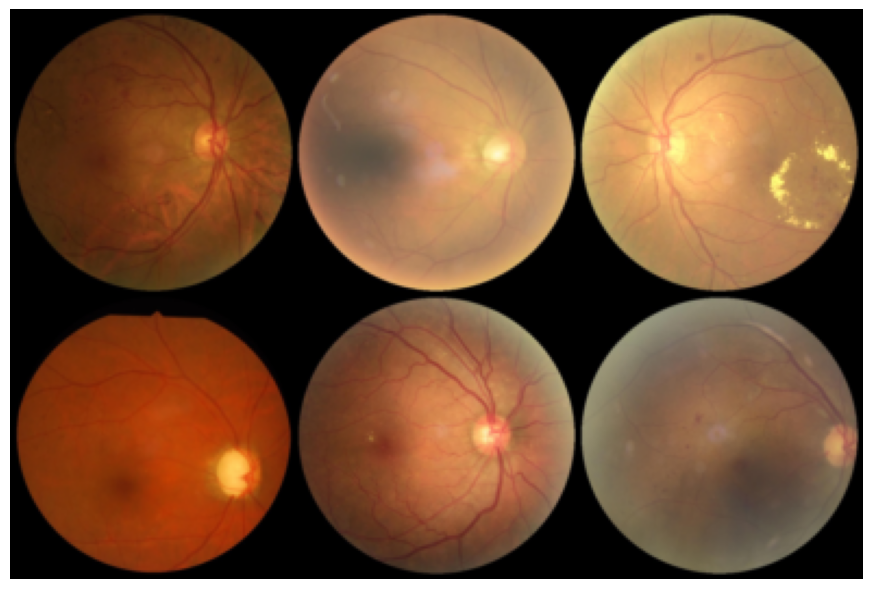

Labels: tensor([1, 1, 1, 2, 1, 1])


In [17]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing images to 128x128 
    transforms.ToTensor()           # Converting images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='/kaggle/working/classified_images/train', transform=transform)

# Call the function to show images
show_transformed_images(dataset)

### This is the image quality like when scaled to 224 pixels

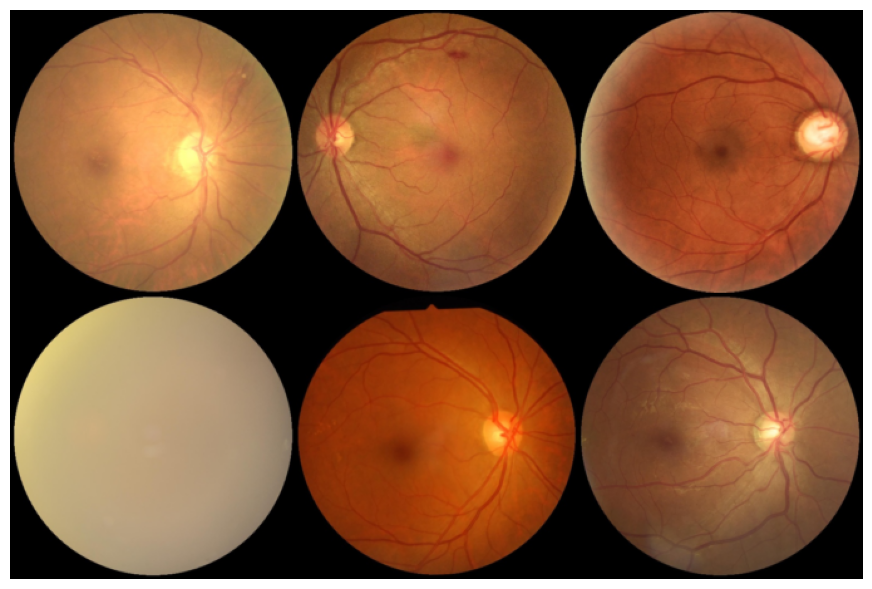

Labels: tensor([1, 1, 2, 0, 1, 1])


In [24]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 128x128 
    transforms.ToTensor()           # Converting images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='/kaggle/working/classified_images/train', transform=transform)

# Call the function to show images
show_transformed_images(dataset)

### This is the image quality when scaled to 448 pixels

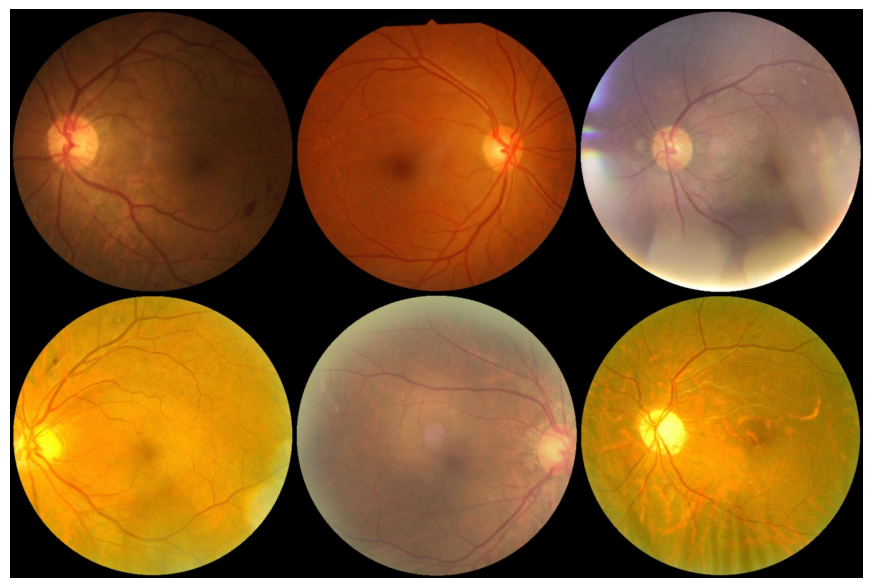

Labels: tensor([1, 1, 1, 1, 1, 1])


In [32]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # Resize images to 448x448
    transforms.ToTensor()           # Convert images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='/kaggle/working/classified_images/train', transform=transform)

# Call the function to show images
show_transformed_images(dataset)

### This is the original image quality without any pixel reducing.

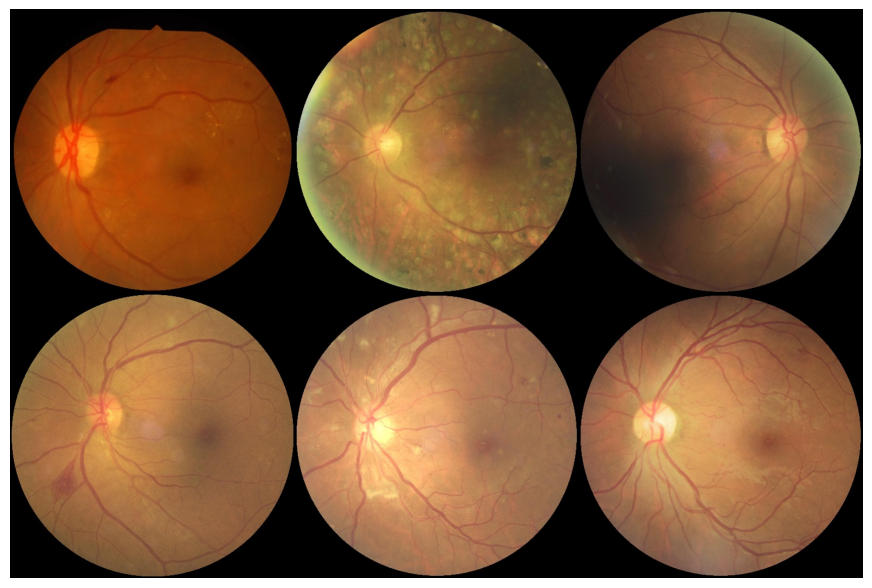

Labels: tensor([1, 1, 1, 1, 1, 1])


In [22]:
# Define your transformations
transform = transforms.Compose([
    # transforms.Resize((448, 448)), 
    transforms.ToTensor()           # Convert images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='/kaggle/working/classified_images/train', transform=transform)

# Call the function to show images
show_transformed_images(dataset)


#### Counting the number of images

In [33]:
import os

def count_images_in_directory(directory_path):
    class_counts = {}
    for class_name in os.listdir(directory_path):
        class_dir = os.path.join(directory_path, class_name)
        if os.path.isdir(class_dir):
            # Counting files with common image extensions
            image_count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            class_counts[class_name] = image_count
    return class_counts

# Loading the images from train and test folders
train_count_dir = '/kaggle/working/classified_images/train'
val_count_dir = '/kaggle/working/classified_images/train'

# Counting total classes of images in the folders
train_class_counts = count_images_in_directory(train_count_dir)
val_class_counts = count_images_in_directory(val_count_dir)

print(f"Training images count by class: {train_class_counts}")
print(f"Validation images count by class: {val_class_counts}")

Training images count by class: {'Glaucoma': 160, 'Diabetes': 712, 'Cataract': 210}
Validation images count by class: {'Glaucoma': 160, 'Diabetes': 712, 'Cataract': 210}


#### It is true that normalization scales pixel values to a consistent range, improving model training stability and performance which is achieved by adjusting pixel values based on the mean and standard deviation of the dataset.

#### But, because we are working with eye disease, which is a medical domain analysis, keeping the images into it's raw form is necessary, if normalized using mean or median, then the images will not look as original as it is actually and ultimately will produce more biases in the results.

# Next step is to, do various experiments on the images we have with context to how does nn (neural network) models are performing with different scenarios.

#### Experiment 1: First try running a basic machine learninig model (SVM) and check whether it could perform good with existing resources, then try Simple CNN with Original Image Size 

#### Experiment 2: Simple CNN with Different Image Sizes

#### Experiment 3 : CNN with Hyperparameter Tuning

#### Experiment 4 : ResNet50 (pre-trained model)

# --------------SVM not working ----------

Tried using a simple machine learning algorithgm for image classification, but becuase the algorithm is not optimized for gpu, it didn't worked well, the process was stuck at one point and was not running even one epoch for 15 minutes.

In [1]:
def train_and_evaluate_svm(train_loader, test_loader, n_epochs):
    # Getting the number of classes from the training dataset
    num_classes = len(train_loader.dataset.classes)

    # Initializing lists to collect training data and labels
    X_train, y_train = [], []
    
    # Iterating through the training loader to gather images and labels
    for images, labels in train_loader:
        # Appending the images and labels to the lists, converting them to numpy arrays
        X_train.append(images.cpu().numpy())
        y_train.append(labels.cpu().numpy())
    
    # Concatenating all collected images and labels into single numpy arrays
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    # Flattening each image into a 1D vector, suitable for SVM input
    n_samples = X_train.shape[0]
    X_train = X_train.reshape(n_samples, -1) 
    
    # Initializing the SVM model with a linear kernel and enabling probability estimates
    model = svm.SVC(kernel='linear', probability=True)
    
    # Training the SVM model with the collected training data and labels
    model.fit(X_train, y_train)
    
    # Initializing variables to track the best test accuracy and accuracy history
    best_acc = 0
    train_acc_history = []
    test_acc_history = []

    # Iterating through the specified number of epochs
    for epoch in range(n_epochs):
        # Predicting the labels on the training set to calculate training accuracy
        train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred) * 100
        train_acc_history.append(train_accuracy)
        
        # Initializing variables to accumulate the correct predictions and total samples in the test set
        test_correct, test_total = 0, 0
        
        # Iterating through the test loader to predict and evaluate on the test set
        for images, labels in test_loader:
            # Flattening the test images to match the input format of the SVM model
            X_test = images.cpu().numpy().reshape(images.size(0), -1)
            test_pred = model.predict(X_test)
            
            # Counting the number of correct predictions
            test_correct += (test_pred == labels.numpy()).sum()
            # Counting the total number of samples in the test set
            test_total += labels.size(0)
        
        # Calculating the test accuracy as a percentage
        test_accuracy = 100.0 * test_correct / test_total
        test_acc_history.append(test_accuracy)

        # Printing the current epoch, training accuracy, and test accuracy
        print(f"Epoch {epoch + 1}: Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")
        
        # Checking if the current test accuracy is the best observed so far
        if test_accuracy > best_acc:
            # Updating the best accuracy and saving the model checkpoint
            best_acc = test_accuracy
            save_checkpoint(model, epoch, best_acc)
    
    # Indicating that the training process is finished
    print("Finished")
    
    # Plotting the training and validation accuracy over epochs
    plot_metrics(range(1, n_epochs + 1), train_acc_history, test_acc_history)

    return model

def save_checkpoint(model, epoch, best_acc):
    # Creating a dictionary to store the state of the model, including the epoch and best accuracy
    state = {
        'epoch': epoch + 1,
        'best_accuracy': best_acc,
        'model': model,
    }
    # Saving the model state as a checkpoint file
    torch.save(state, 'svm_best_checkpoint.pth.tar')

def plot_metrics(epochs, train_acc, test_acc):
    # Creating a plot for the training and test accuracy over the epochs
    plt.figure()
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
# Defining the transformations for data preprocessing
transform = transforms.Compose([
    # Resizing images to 224x224 pixels to ensure consistent input size for the model
    transforms.Resize((224, 224)),
    # Converting images to PyTorch tensors
    transforms.ToTensor(),
    # Normalizing the images using mean and standard deviation values (commonly used for pretrained models like ResNet)
    # Commented out here, but can be uncommented for normalization if needed
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Creating the training dataset from the image folder
# Images will be loaded from 'train_dir' and transformed using the defined transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Creating the test dataset similarly, with images loaded from 'test_dir'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Creating the data loaders to iterate through the training and test datasets
train_loader = DataLoader(
    train_dataset,   
    batch_size=32,    
    shuffle=True,     
    num_workers=4     
)

# Creating the test data loader with similar settings but without shuffling
test_loader = DataLoader(
    test_dataset,    
    batch_size=32,    
    shuffle=False,
    num_workers=4   
)

# Choosing the device to run the model on (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_epochs = 10

model = train_and_evaluate_svm(train_loader, test_loader, n_epochs)


# Experiment 1 - Simple CNN with Original Size of Images

## Exp-1 with SimpleCNN

#### Convolutional Layers (conv1, conv2, conv3):
* These layers extract features from the input image. Each layer uses a 3x3 kernel with padding to preserve the spatial dimensions.
* conv1: Takes a 3-channel input (like an RGB image) and outputs 32 feature maps.
* conv2: Takes the 32 feature maps from conv1 and outputs 64 feature maps.
* conv3: Takes the 64 feature maps from conv2 and outputs 128 feature maps.

#### Pooling Layer (pool):
* The max-pooling operation reduces the spatial dimensions of the feature maps by a factor of 2. This helps in reducing the computational load and the number of parameters in the subsequent fully connected layers.

#### Fully Connected Layers (fc1, fc2):
* fc1: A fully connected layer that takes the flattened output of the final convolutional layer and outputs 512 features.
* fc2: The final layer that maps the 512 features to the num_classes output, corresponding to the number of categories in the classification task.

#### The `train_and_evaluate_cnn_kfold` function:
* Initialization:
* Sets up k-fold cross-validation with KFold.
* Initializes variables to track the best model, accuracy, and fold.

### K-Fold Loop:
#### For each fold:
#### Data Splitting:
* Splits the dataset into training and validation subsets.
* Creates data loaders for efficient data handling.

#### Model Setup:
* Initializes the SimpleCNN model, loss function, and optimizer.
* Training and Validation:
* Trains the model for n_epochs.
* Calculates and tracks training and validation accuracy/loss.
* Validates the model after each epoch and tracks predictions for confusion matrix generation.

#### Plotting:
* Plots training and validation loss/accuracy curves.
* Generates a confusion matrix to visualize classification performance.
* Best Model Selection:
* Updates the best model if the current fold's validation accuracy exceeds the previous best.

#### Saving the Best Model:
* Saves the model with the highest validation accuracy across all folds.


In [45]:
def train_and_evaluate_cnn_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device,
                                 learning_rate: float = 0.001, k: int = 5):
    # Getting the number of classes from the dataset
    num_classes = len(dataset.classes)

    # Initializing K-Fold cross-validation with k splits
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initializing variables to track the best model and accuracy
    best_model = None
    best_acc = 0
    best_acc_fold = 0
    fold_results = []

    # Looping through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        # Printing the number of images in each subset
        print(f"Train indices count: {len(train_idx)}, Validation indices count: {len(val_idx)}")

        # Creating subsets for training and validation
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Ensuring that all images are included in the subsets
        assert len(train_subset) + len(val_subset) == len(dataset), "Subset length mismatch!"

        # Creating data loaders for training and validation
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
        
        # Initializing the model, loss function, and optimizer
        model = SimpleCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Lists to store accuracy and loss history
        train_acc_history = []
        val_acc_history = []
        epoch_losses = []
        val_losses = []
        best_epoch_labels = []
        best_epoch_preds = []
        
        # Variables to track the best epoch in the current fold
        best_epoch = -1
        best_epoch_acc = 0
        best_epoch_state = None

        # Training loop for each epoch
        for epoch in range(n_epochs):
            model.train()  # Set model to training mode
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            # Loop through the training data
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Accumulate loss and correct predictions
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            # Calculating training accuracy and loss
            train_accuracy = 100.0 * correct_train / total_train
            train_acc_history.append(train_accuracy)
            epoch_loss = running_loss / total_train
            epoch_losses.append(epoch_loss)

            model.eval() 
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            fold_labels = []
            fold_preds = []

            # Looping through the validation data
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    fold_labels.extend(labels.cpu().numpy())
                    fold_preds.extend(predicted.cpu().numpy())

            # Calculating validation accuracy and loss
            val_accuracy = 100.0 * correct_val / total_val
            val_acc_history.append(val_accuracy)
            val_loss = running_val_loss / total_val
            val_losses.append(val_loss)

            # Saving the best epoch in the current fold
            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            # Printing metrics for the current epoch
            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Classified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Classified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        # Plotting loss and accuracy for the current fold
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        # Calculating confusion matrix and classification report for the best epoch in the current fold
        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds)
        print(f"The best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")

        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        # Storing results of the current fold
        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes)
        })

        # Updating the best model across all folds if current fold's model is better
        if best_epoch_acc > best_acc:
            best_acc = best_epoch_acc
            best_acc_fold = fold + 1
            best_model = best_epoch_state

    # Saving the best model across all folds
    if best_model:
        torch.save(best_model, f'best_cnn_model_fold_{best_acc_fold}_accuracy_{best_acc:.2f}.pth')

    # Comparing all best models and print the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")
    
    # Printing confusion matrix and classification report for the best overall model
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    # Saving the best overall model
    torch.save(best_overall['model_state'], f'best_overall_cnn_model_fold_{best_overall["fold"]}_accuracy_{best_overall["val_accuracy"]:.2f}.pth')

    # Printing final message
    print("Training and evaluation finished.")










Fold 1/5







Train indices count: 865, Validation indices count: 217







Epoch 1:







  -- Training dataset. Claasified 545 out of 865 images to correct labels (63.006%). Epoch loss: 0.917







   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.806







Epoch 2:







  -- Training dataset. Claasified 565 out of 865 images to correct labels (65.318%). Epoch loss: 0.853







   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.786







Epoch 3:







  -- Training dataset. Claasified 570 out of 865 images to correct labels (65.896%). Epoch loss: 0.819







   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.762







Epoch 4:







  -- Training dataset. Claasified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.785







   - Validation dataset. Claasified 152 out of 217 images to correct labe

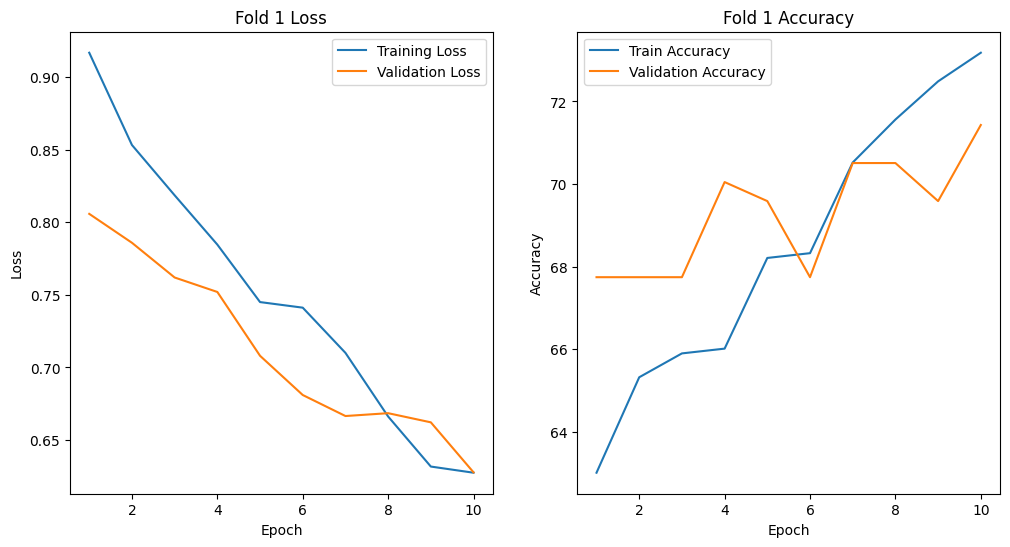

The best Epoch (Epoch 10) of Fold 1:















Classification Report for the Best Epoch (Epoch 10) of Fold 1:







              precision    recall  f1-score   support















    Cataract       0.64      0.21      0.32        42







    Diabetes       0.74      0.94      0.83       147







    Glaucoma       0.50      0.29      0.36        28















    accuracy                           0.71       217







   macro avg       0.63      0.48      0.50       217







weighted avg       0.69      0.71      0.67       217























Fold 2/5







Train indices count: 865, Validation indices count: 217







Epoch 1:







  -- Training dataset. Claasified 558 out of 865 images to correct labels (64.509%). Epoch loss: 0.908







   - Validation dataset. Claasified 154 out of 217 images to correct labels (70.968%). Epoch loss: 0.783







Epoch 2:







  -- Training dataset. Claasified 558 out of 865 images to correct labels (64.509%). E

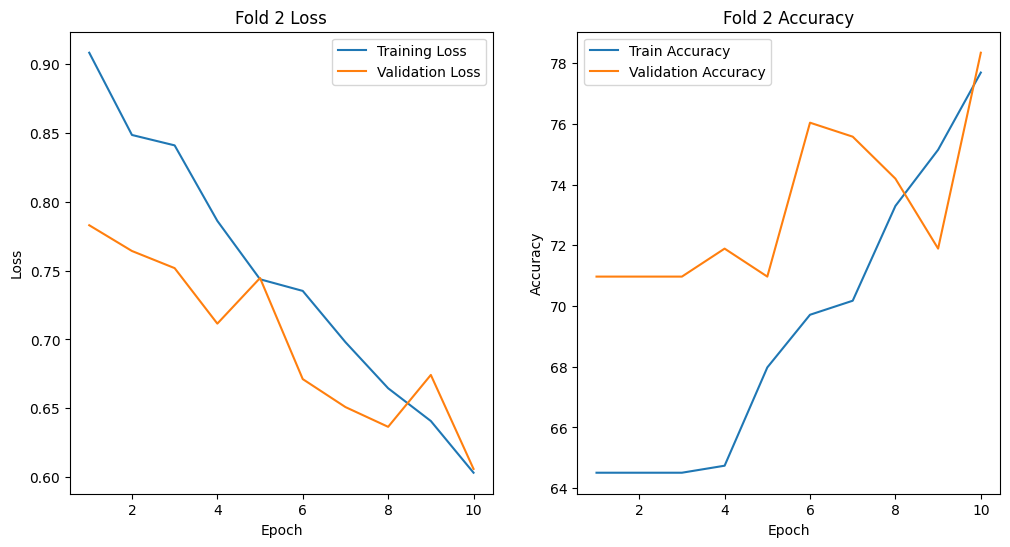

The best Epoch (Epoch 10) of Fold 2:















Classification Report for the Best Epoch (Epoch 10) of Fold 2:







              precision    recall  f1-score   support















    Cataract       0.65      0.49      0.56        35







    Diabetes       0.83      0.93      0.87       154







    Glaucoma       0.56      0.36      0.43        28















    accuracy                           0.78       217







   macro avg       0.68      0.59      0.62       217







weighted avg       0.76      0.78      0.77       217























Fold 3/5







Train indices count: 866, Validation indices count: 216







Epoch 1:







  -- Training dataset. Claasified 564 out of 866 images to correct labels (65.127%). Epoch loss: 0.904







   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.893







Epoch 2:







  -- Training dataset. Claasified 580 out of 866 images to correct labels (66.975%). E

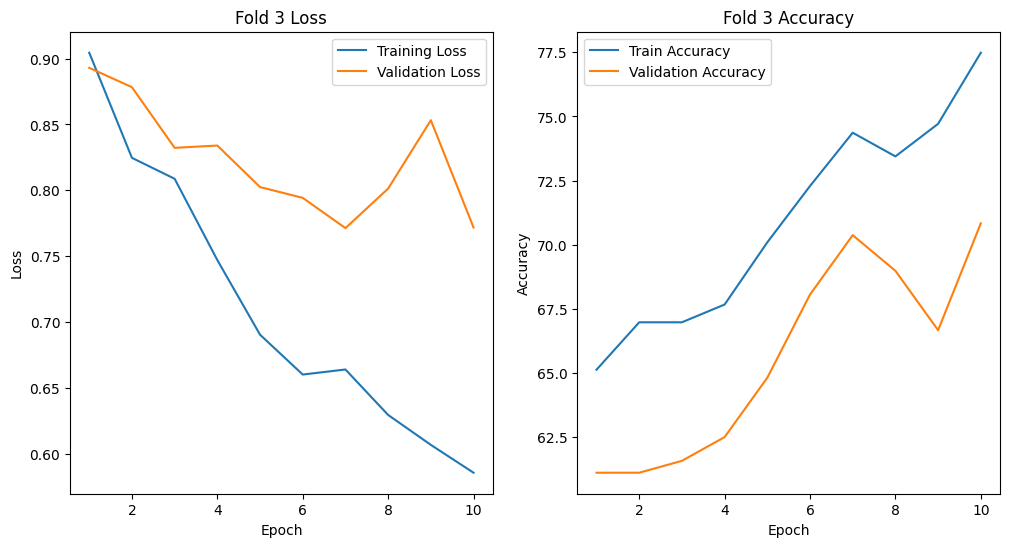

The best Epoch (Epoch 10) of Fold 3:















Classification Report for the Best Epoch (Epoch 10) of Fold 3:







              precision    recall  f1-score   support















    Cataract       0.63      0.63      0.63        51







    Diabetes       0.79      0.83      0.81       132







    Glaucoma       0.42      0.33      0.37        33















    accuracy                           0.71       216







   macro avg       0.61      0.60      0.60       216







weighted avg       0.70      0.71      0.70       216























Fold 4/5







Train indices count: 866, Validation indices count: 216







Epoch 1:







  -- Training dataset. Claasified 548 out of 866 images to correct labels (63.279%). Epoch loss: 0.914







   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.922







Epoch 2:







  -- Training dataset. Claasified 580 out of 866 images to correct labels (66.975%). E

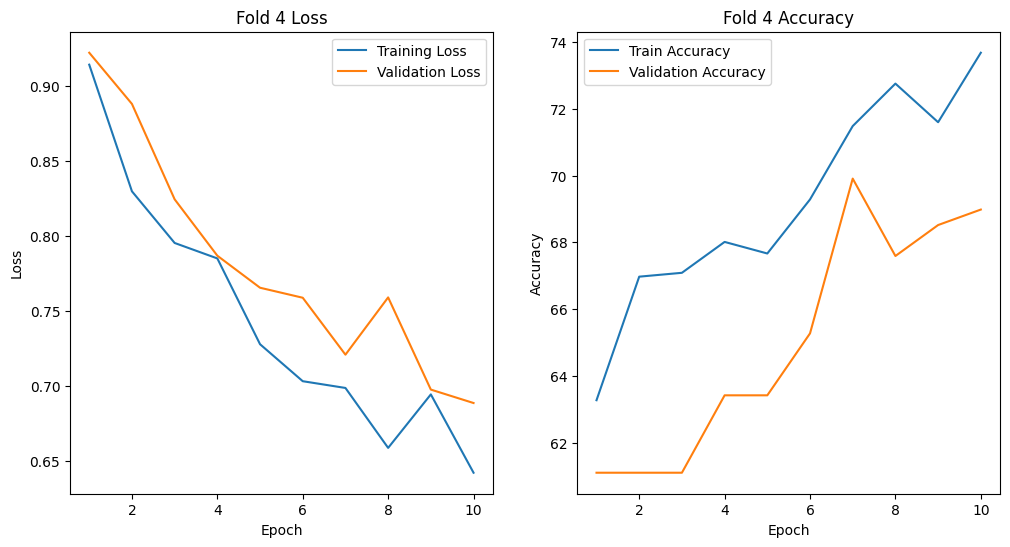

The best Epoch (Epoch 7) of Fold 4:















Classification Report for the Best Epoch (Epoch 7) of Fold 4:







              precision    recall  f1-score   support















    Cataract       0.60      0.46      0.52        46







    Diabetes       0.72      0.94      0.82       132







    Glaucoma       0.67      0.16      0.26        38















    accuracy                           0.70       216







   macro avg       0.66      0.52      0.53       216







weighted avg       0.69      0.70      0.65       216























Fold 5/5







Train indices count: 866, Validation indices count: 216







Epoch 1:







  -- Training dataset. Claasified 551 out of 866 images to correct labels (63.626%). Epoch loss: 0.915







   - Validation dataset. Claasified 147 out of 216 images to correct labels (68.056%). Epoch loss: 0.849







Epoch 2:







  -- Training dataset. Claasified 565 out of 866 images to correct labels (65.242%). Epo

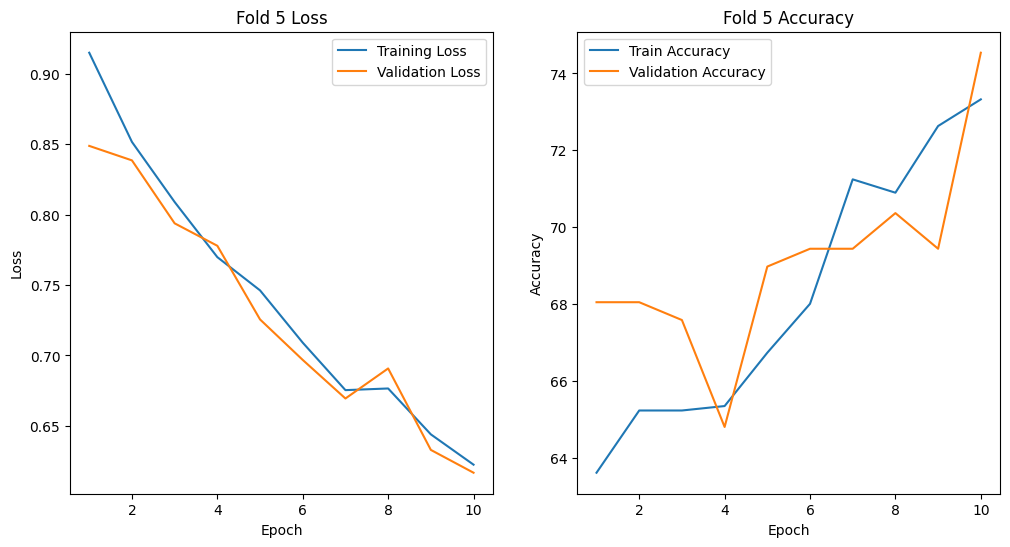

The best Epoch (Epoch 10) of Fold 5:















Classification Report for the Best Epoch (Epoch 10) of Fold 5:







              precision    recall  f1-score   support















    Cataract       0.68      0.47      0.56        36







    Diabetes       0.76      0.95      0.85       147







    Glaucoma       0.57      0.12      0.20        33















    accuracy                           0.75       216







   macro avg       0.67      0.52      0.53       216







weighted avg       0.72      0.75      0.70       216























Best overall model from fold 2 with validation accuracy: 78.34%















Confusion Matrix for the best model (Fold 2):


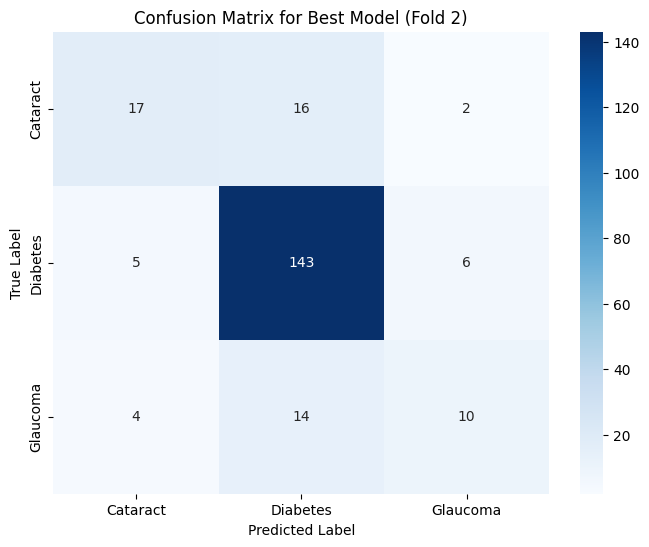









Classification Report for the best model (Fold 2):







              precision    recall  f1-score   support















    Cataract       0.65      0.49      0.56        35







    Diabetes       0.83      0.93      0.87       154







    Glaucoma       0.56      0.36      0.43        28















    accuracy                           0.78       217







   macro avg       0.68      0.59      0.62       217







weighted avg       0.76      0.78      0.77       217















Training and evaluation finished.


In [47]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Initializing the first convolutional layer, taking 3-channel input and outputting 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Initializing the second convolutional layer, taking 32-channel input and outputting 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Initializing the third convolutional layer, taking 64-channel input and outputting 128 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Initializing the pooling layer, which will downsample the input by a factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Initializing the first fully connected layer, taking the flattened convolutional output and outputting 512 features
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        # Initializing the second fully connected layer, taking 512 features and outputting the number of class predictions
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Passing input through the first convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Passing through the second convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Passing through the third convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flattening the output to feed it into the fully connected layer
        x = x.view(x.size(0), -1)

        # Dynamically adjusting the input size of fc1 if the flattened size does not match the expected size
        if self.fc1.in_features != x.size(1):
            # Reinitializing the first fully connected layer with the new input size
            self.fc1 = nn.Linear(x.size(1), 512).to(x.device)

        # Passing through the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Passing through the second fully connected layer to produce class scores
        x = self.fc2(x)
        return x

# Define transformations for data preprocessing
transform = transforms.Compose([
#     transforms.Resize((128, 128)), 
    transforms.ToTensor(),
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 2

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)

#### Running the model with original dataset was not easy initially, as different images are of different shape of pixel sizes.

#### To handle this situation there is a solution available by which used.
* `x = x.view(x.size(0), -1)`After the convolutional layers have processed the image, the output tensor x has a shape of (batch_size, num_channels, height, width). The .view(x.size(0), -1) operation reshapes this tensor into a 2D tensor where each image is flattened into a single vector. The new shape is (batch_size, num_features), where num_features is the product of the number of channels, height, and width after the last convolutional layer.
* `if self.fc1.in_features != x.size(1):
    self.fc1 = nn.Linear(x.size(1), 512).to(x.device)`:
* This block of code ensures that the input size of the first fully connected layer (fc1) matches the flattened size of the output tensor x.

* self.fc1.in_features represents the expected number of input features for the fully connected layer fc1.
* x.size(1) gives the actual number of input features after flattening, which can vary depending on the input image size.If these two values do not match (i.e., the expected size and the actual size are different), the code reinitializes the fc1 layer with a new input size (x.size(1)) and an output size of 512. The .to(x.device) ensures that the layer is moved to the same device (CPU or GPU) as the rest of the model.

#### Flattening the output of the convolutional layers to get a fixed-size feature vector.Dynamically adjusting the input size of the first fully connected layer to accommodate the varying size of this feature vector.

#### Overall Trends:
* Training Accuracy: Increased steadily across all folds, reaching up to 78.060% in Fold 4/5.
* Training Loss: Decreased consistently, indicating improved model performance.
* Validation Accuracy: Generally improved, with a notable decrease in Fold 4/5.
* Validation Loss: Decreased overall but increased in Fold 4/5, suggesting potential overfitting in that fold.
#### The model shows overall improvement in training and validation performance, though Fold 4/5 had some issues with validation metrics.

# Experiment 2 - Simple CNN with Different Image Sizes

## Simple CNN

In [15]:
def train_and_evaluate_cnn_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device,
                                 learning_rate: float = 0.001, k: int = 5):
    num_classes = len(dataset.classes)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    best_model = None
    best_acc = 0
    best_acc_fold = 0
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        # Checking the number of images in each subset
        print(f"Train indices count: {len(train_idx)}, Validation indices count: {len(val_idx)}")

        # Ensuring the subsets are created correctly
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Double-checking that all images are included
        assert len(train_subset) + len(val_subset) == len(dataset), "Subset length mismatch!"

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
        

        model = SimpleCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_acc_history = []
        val_acc_history = []
        epoch_losses = []
        val_losses = []
        best_epoch_labels = []
        best_epoch_preds = []
        
        best_epoch = -1
        best_epoch_acc = 0
        best_epoch_state = None

        for epoch in range(n_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100.0 * correct_train / total_train
            train_acc_history.append(train_accuracy)
            epoch_loss = running_loss / total_train
            epoch_losses.append(epoch_loss)

            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            fold_labels = []
            fold_preds = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    fold_labels.extend(labels.cpu().numpy())
                    fold_preds.extend(predicted.cpu().numpy())

            val_accuracy = 100.0 * correct_val / total_val
            val_acc_history.append(val_accuracy)
            val_loss = running_val_loss / total_val
            val_losses.append(val_loss)

            # Track the best epoch within this fold
            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Claasified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Claasified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds)
        print(f"The best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")

        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes)
        })

        if best_epoch_acc > best_acc:
            best_acc = best_epoch_acc
            best_acc_fold = fold + 1
            best_model = best_epoch_state

    if best_model:
        # Saving the best model across all folds
        torch.save(best_model, f'best_cnn_model_fold_{best_acc_fold}_accuracy_{best_acc:.2f}.pth')

    # Comparing all best models and printing the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")
    
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    # Saving the best overall model
    torch.save(best_overall['model_state'], f'best_overall_cnn_model_fold_{best_overall["fold"]}_accuracy_{best_overall["val_accuracy"]:.2f}.pth')

    print("Training and evaluation finished.")


## 2.1 Simple CNN with Image size (128 x 128) pixels 

Updated size here This size here needs to be changes everytime changing the shape of the images, if using without rescalled images
#### self.fc1 = nn.Linear(128 * 16 * 16, 512)  

Updated size here This size here needs to be changes everytime changing the shape of the images, if using without rescalled images
#### x = x.view(-1, 128 * 16 * 16) 









Fold 1/5







Train indices count: 865, Validation indices count: 217







Epoch 1:







  -- Training dataset. Claasified 549 out of 865 images to correct labels (63.468%). Epoch loss: 0.924







   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.812







Epoch 2:







  -- Training dataset. Claasified 565 out of 865 images to correct labels (65.318%). Epoch loss: 0.845







   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.795







Epoch 3:







  -- Training dataset. Claasified 567 out of 865 images to correct labels (65.549%). Epoch loss: 0.813







   - Validation dataset. Claasified 148 out of 217 images to correct labels (68.203%). Epoch loss: 0.736







Epoch 4:







  -- Training dataset. Claasified 579 out of 865 images to correct labels (66.936%). Epoch loss: 0.746







   - Validation dataset. Claasified 149 out of 217 images to correct labe

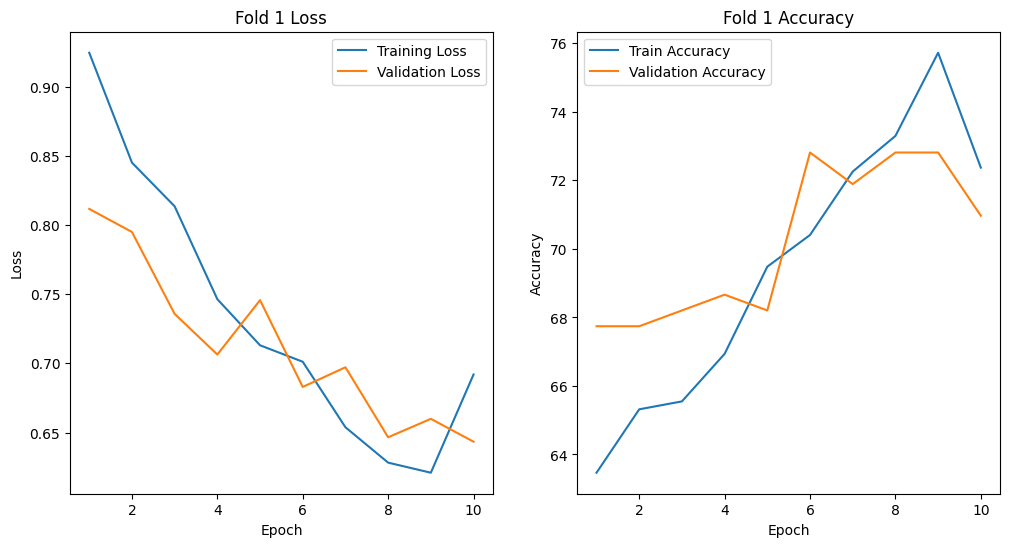

The best Epoch (Epoch 6) of Fold 1:















Classification Report for the Best Epoch (Epoch 6) of Fold 1:







              precision    recall  f1-score   support















    Cataract       0.67      0.29      0.40        42







    Diabetes       0.78      0.93      0.84       147







    Glaucoma       0.42      0.36      0.38        28















    accuracy                           0.73       217







   macro avg       0.62      0.52      0.54       217







weighted avg       0.71      0.73      0.70       217























Fold 2/5







Train indices count: 865, Validation indices count: 217







Epoch 1:







  -- Training dataset. Claasified 544 out of 865 images to correct labels (62.890%). Epoch loss: 0.909







   - Validation dataset. Claasified 154 out of 217 images to correct labels (70.968%). Epoch loss: 0.792







Epoch 2:







  -- Training dataset. Claasified 558 out of 865 images to correct labels (64.509%). Epo

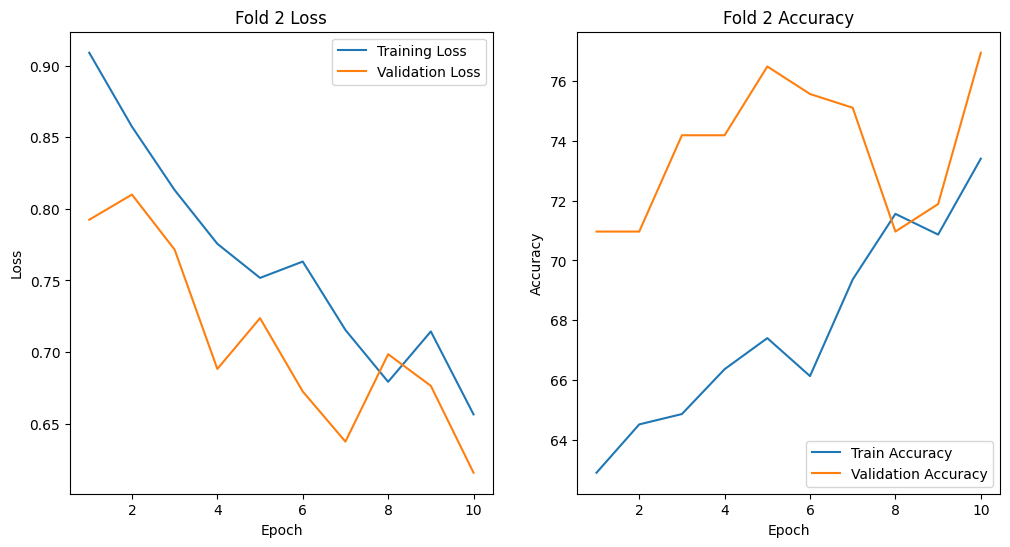

The best Epoch (Epoch 10) of Fold 2:















Classification Report for the Best Epoch (Epoch 10) of Fold 2:







              precision    recall  f1-score   support















    Cataract       0.69      0.26      0.37        35







    Diabetes       0.79      0.97      0.87       154







    Glaucoma       0.60      0.32      0.42        28















    accuracy                           0.77       217







   macro avg       0.69      0.52      0.55       217







weighted avg       0.75      0.77      0.73       217























Fold 3/5







Train indices count: 866, Validation indices count: 216







Epoch 1:







  -- Training dataset. Claasified 546 out of 866 images to correct labels (63.048%). Epoch loss: 0.922







   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.907







Epoch 2:







  -- Training dataset. Claasified 580 out of 866 images to correct labels (66.975%). E

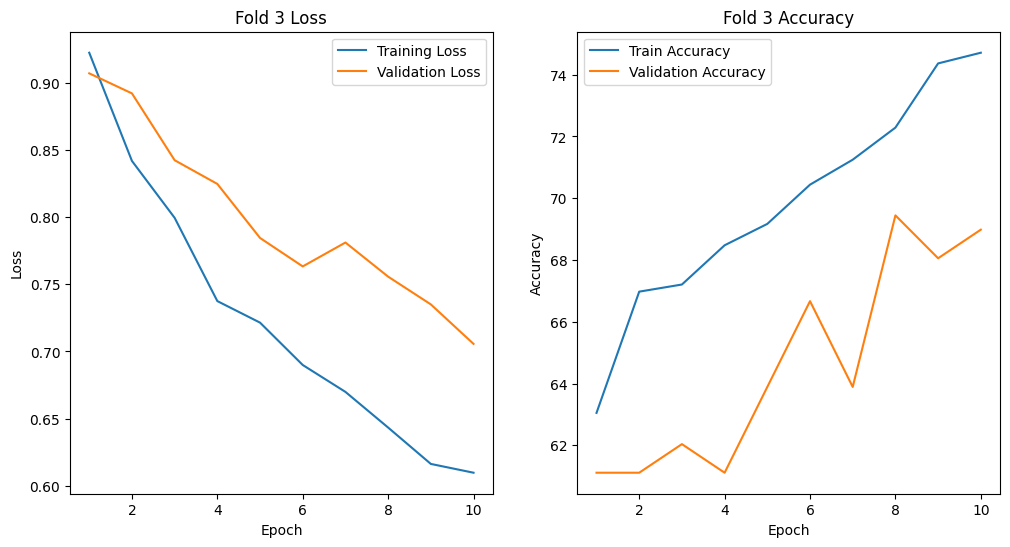

The best Epoch (Epoch 8) of Fold 3:















Classification Report for the Best Epoch (Epoch 8) of Fold 3:







              precision    recall  f1-score   support















    Cataract       0.55      0.53      0.54        51







    Diabetes       0.75      0.87      0.81       132







    Glaucoma       0.57      0.24      0.34        33















    accuracy                           0.69       216







   macro avg       0.62      0.55      0.56       216







weighted avg       0.68      0.69      0.67       216























Fold 4/5







Train indices count: 866, Validation indices count: 216







Epoch 1:







  -- Training dataset. Claasified 555 out of 866 images to correct labels (64.088%). Epoch loss: 0.927







   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.897







Epoch 2:







  -- Training dataset. Claasified 580 out of 866 images to correct labels (66.975%). Epo

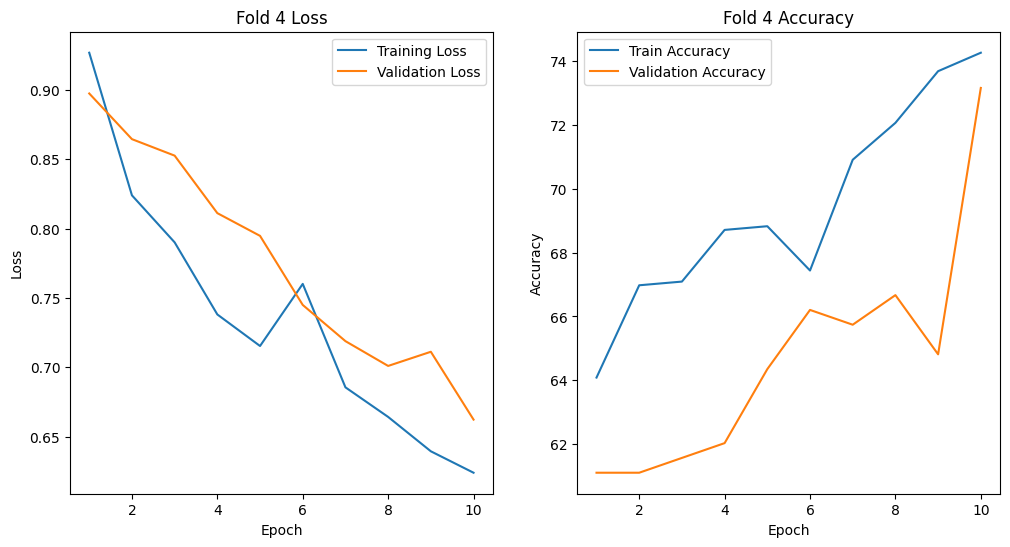

The best Epoch (Epoch 10) of Fold 4:















Classification Report for the Best Epoch (Epoch 10) of Fold 4:







              precision    recall  f1-score   support















    Cataract       0.70      0.46      0.55        46







    Diabetes       0.75      0.94      0.84       132







    Glaucoma       0.62      0.34      0.44        38















    accuracy                           0.73       216







   macro avg       0.69      0.58      0.61       216







weighted avg       0.72      0.73      0.71       216























Fold 5/5







Train indices count: 866, Validation indices count: 216







Epoch 1:







  -- Training dataset. Claasified 553 out of 866 images to correct labels (63.857%). Epoch loss: 0.912







   - Validation dataset. Claasified 147 out of 216 images to correct labels (68.056%). Epoch loss: 0.851







Epoch 2:







  -- Training dataset. Claasified 565 out of 866 images to correct labels (65.242%). E

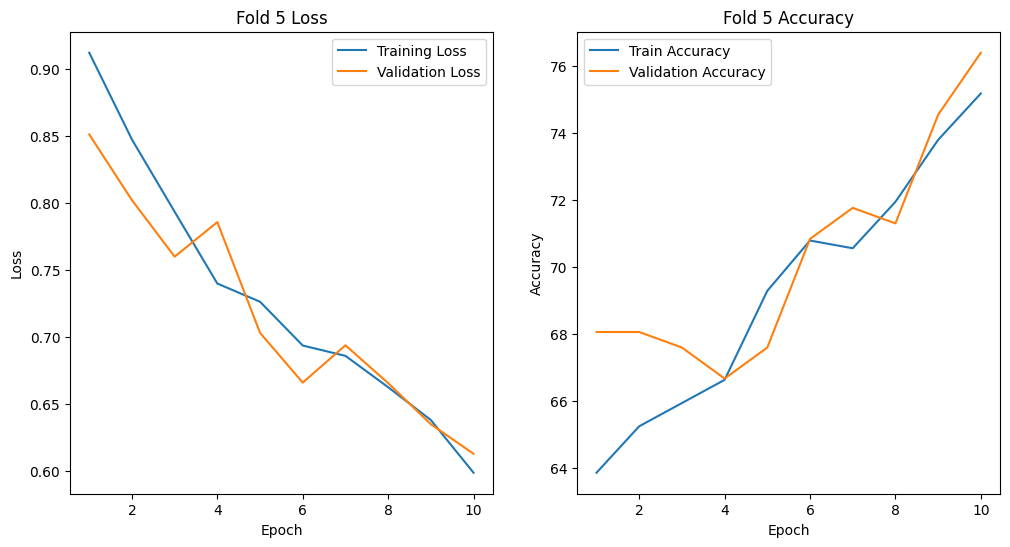

The best Epoch (Epoch 10) of Fold 5:















Classification Report for the Best Epoch (Epoch 10) of Fold 5:







              precision    recall  f1-score   support















    Cataract       0.80      0.44      0.57        36







    Diabetes       0.78      0.95      0.86       147







    Glaucoma       0.56      0.27      0.37        33















    accuracy                           0.76       216







   macro avg       0.71      0.56      0.60       216







weighted avg       0.75      0.76      0.73       216























Best overall model from fold 2 with validation accuracy: 76.96%















Confusion Matrix for the best model (Fold 2):


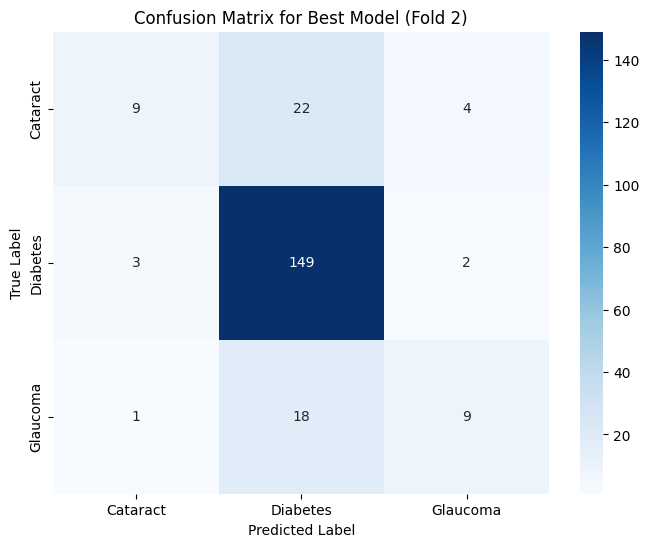









Classification Report for the best model (Fold 2):







              precision    recall  f1-score   support















    Cataract       0.69      0.26      0.37        35







    Diabetes       0.79      0.97      0.87       154







    Glaucoma       0.60      0.32      0.42        28















    accuracy                           0.77       217







   macro avg       0.69      0.52      0.55       217







weighted avg       0.75      0.77      0.73       217















Training and evaluation finished.


In [49]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Initializing the first convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Initializing the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Initializing the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Initializing the pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Initializing the first fully connected layer 
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        # Initializing the second fully connected layer 
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Passing input through the first convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Passing through the second convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Passing through the third convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flattening the output to feed it into the fully connected layer
        x = x.view(x.size(0), -1)

        # Dynamically adjusting the input size of fc1 if the flattened size does not match the expected size
        if self.fc1.in_features != x.size(1):
            # Reinitializing the first fully connected layer with the new input size
            self.fc1 = nn.Linear(x.size(1), 512).to(x.device)

        # Passing through the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Passing through the second fully connected layer to produce class scores
        x = self.fc2(x)
        return x

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 2

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)

## 2.2 Simple CNN with Image size (224 x 224) pixels





Fold 1/5



Train indices count: 865, Validation indices count: 217



Epoch 1:



  -- Training dataset. Claasified 506 out of 865 images to correct labels (58.497%). Epoch loss: 1.034



   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.795



Epoch 2:



  -- Training dataset. Claasified 579 out of 865 images to correct labels (66.936%). Epoch loss: 0.787



   - Validation dataset. Claasified 152 out of 217 images to correct labels (70.046%). Epoch loss: 0.713



Epoch 3:



  -- Training dataset. Claasified 597 out of 865 images to correct labels (69.017%). Epoch loss: 0.735



   - Validation dataset. Claasified 152 out of 217 images to correct labels (70.046%). Epoch loss: 0.678



Epoch 4:



  -- Training dataset. Claasified 628 out of 865 images to correct labels (72.601%). Epoch loss: 0.696



   - Validation dataset. Claasified 156 out of 217 images to correct labels (71.889%). Epoch loss: 0.669



Epoch 5:



  -- Trai

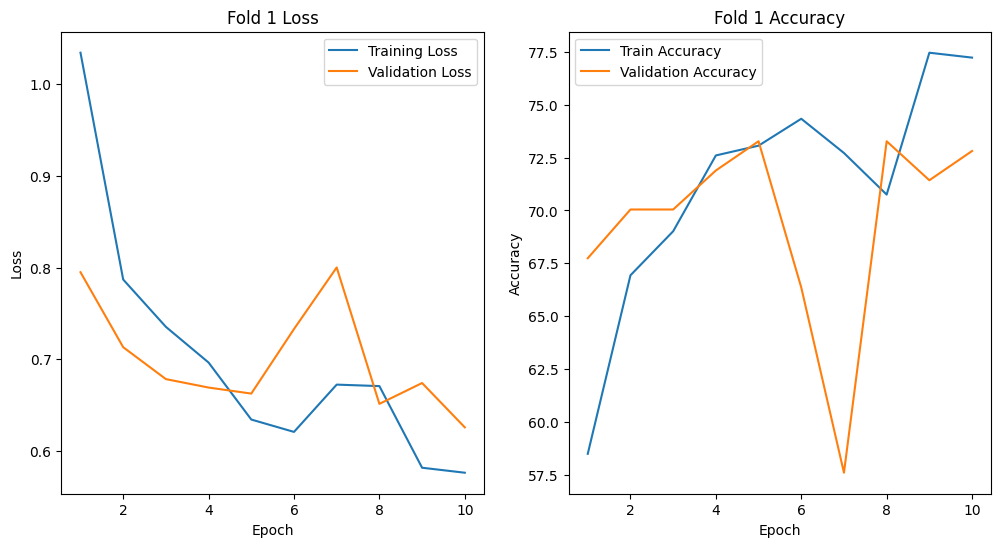

The best Epoch (Epoch 5) of Fold 1:







Classification Report for the Best Epoch (Epoch 5) of Fold 1:



              precision    recall  f1-score   support







    Cataract       0.51      0.83      0.63        42



    Diabetes       0.85      0.82      0.83       147



    Glaucoma       0.67      0.14      0.24        28







    accuracy                           0.73       217



   macro avg       0.67      0.60      0.57       217



weighted avg       0.76      0.73      0.71       217











Fold 2/5



Train indices count: 865, Validation indices count: 217



Epoch 1:



  -- Training dataset. Claasified 511 out of 865 images to correct labels (59.075%). Epoch loss: 1.075



   - Validation dataset. Claasified 156 out of 217 images to correct labels (71.889%). Epoch loss: 0.750



Epoch 2:



  -- Training dataset. Claasified 554 out of 865 images to correct labels (64.046%). Epoch loss: 0.824



   - Validation dataset. Claasified 156 out of 217 images to c

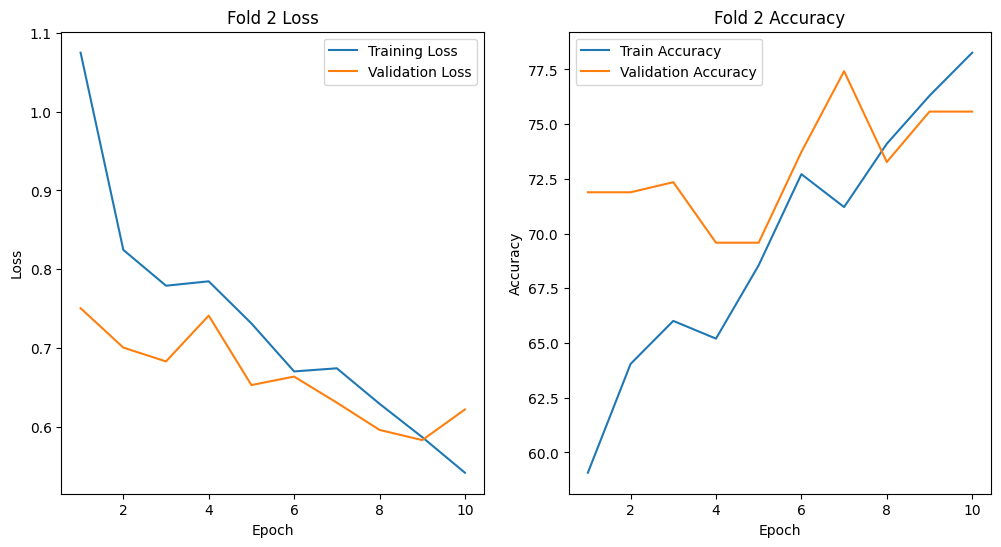

The best Epoch (Epoch 7) of Fold 2:







Classification Report for the Best Epoch (Epoch 7) of Fold 2:



              precision    recall  f1-score   support







    Cataract       0.59      0.66      0.62        35



    Diabetes       0.82      0.92      0.87       154



    Glaucoma       0.57      0.14      0.23        28







    accuracy                           0.77       217



   macro avg       0.66      0.57      0.57       217



weighted avg       0.75      0.77      0.75       217











Fold 3/5



Train indices count: 866, Validation indices count: 216



Epoch 1:



  -- Training dataset. Claasified 570 out of 866 images to correct labels (65.820%). Epoch loss: 0.943



   - Validation dataset. Claasified 134 out of 216 images to correct labels (62.037%). Epoch loss: 0.846



Epoch 2:



  -- Training dataset. Claasified 600 out of 866 images to correct labels (69.284%). Epoch loss: 0.747



   - Validation dataset. Claasified 143 out of 216 images to c

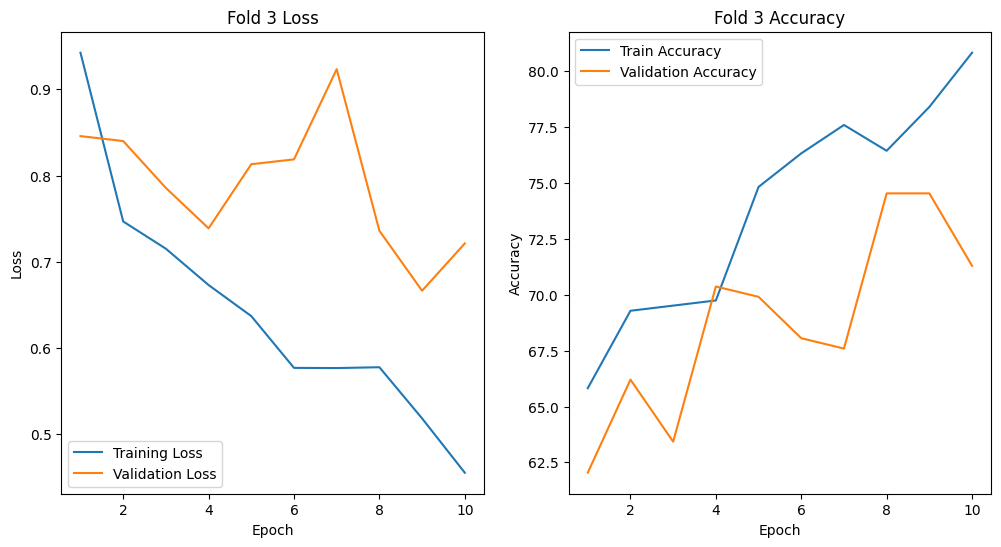

The best Epoch (Epoch 8) of Fold 3:







Classification Report for the Best Epoch (Epoch 8) of Fold 3:



              precision    recall  f1-score   support







    Cataract       0.77      0.53      0.63        51



    Diabetes       0.77      0.92      0.84       132



    Glaucoma       0.54      0.39      0.46        33







    accuracy                           0.75       216



   macro avg       0.69      0.61      0.64       216



weighted avg       0.74      0.75      0.73       216











Fold 4/5



Train indices count: 866, Validation indices count: 216



Epoch 1:



  -- Training dataset. Claasified 582 out of 866 images to correct labels (67.206%). Epoch loss: 1.060



   - Validation dataset. Claasified 135 out of 216 images to correct labels (62.500%). Epoch loss: 0.908



Epoch 2:



  -- Training dataset. Claasified 605 out of 866 images to correct labels (69.861%). Epoch loss: 0.771



   - Validation dataset. Claasified 143 out of 216 images to c

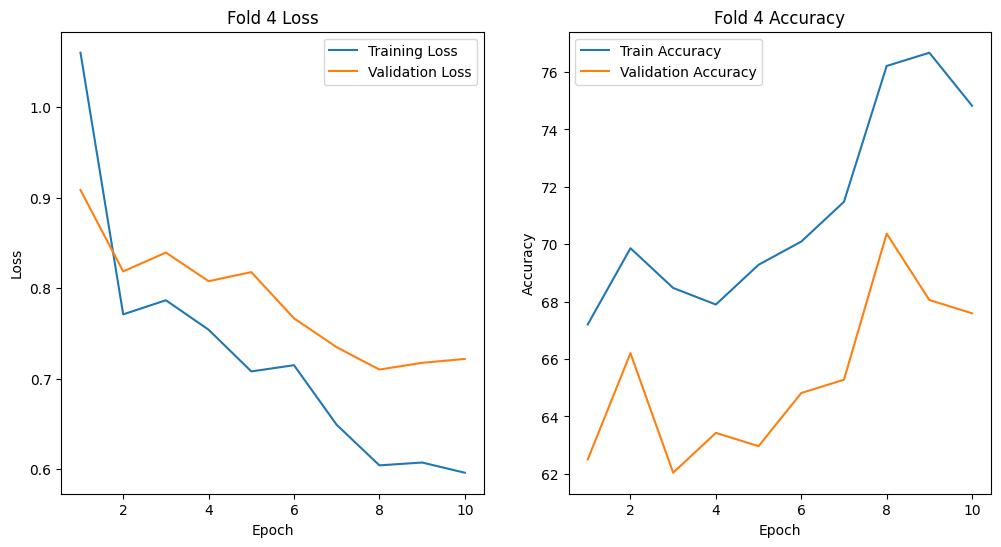

The best Epoch (Epoch 8) of Fold 4:







Classification Report for the Best Epoch (Epoch 8) of Fold 4:



              precision    recall  f1-score   support







    Cataract       0.62      0.67      0.65        46



    Diabetes       0.76      0.86      0.81       132



    Glaucoma       0.44      0.21      0.29        38







    accuracy                           0.70       216



   macro avg       0.61      0.58      0.58       216



weighted avg       0.68      0.70      0.68       216











Fold 5/5



Train indices count: 866, Validation indices count: 216



Epoch 1:



  -- Training dataset. Claasified 515 out of 866 images to correct labels (59.469%). Epoch loss: 0.976



   - Validation dataset. Claasified 150 out of 216 images to correct labels (69.444%). Epoch loss: 0.752



Epoch 2:



  -- Training dataset. Claasified 589 out of 866 images to correct labels (68.014%). Epoch loss: 0.808



   - Validation dataset. Claasified 152 out of 216 images to c

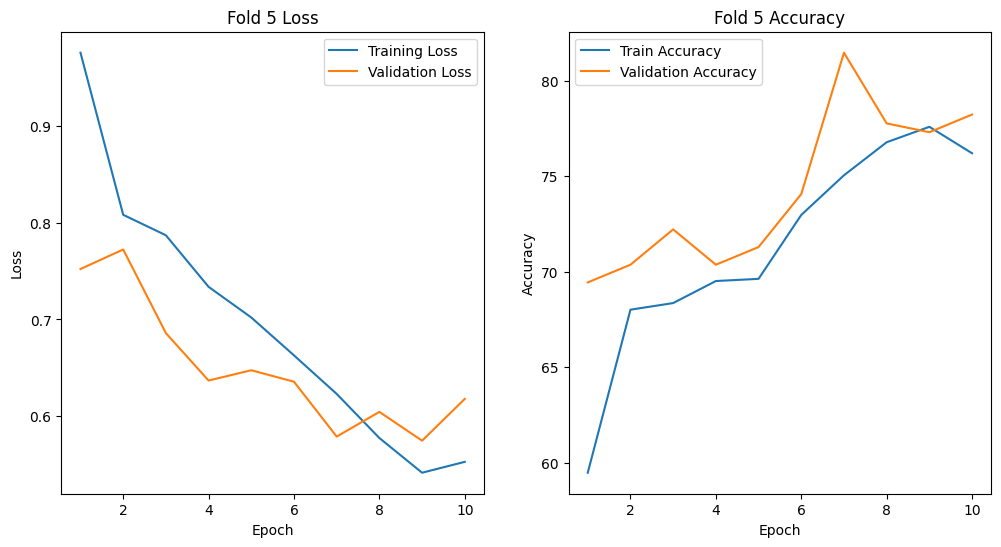

The best Epoch (Epoch 7) of Fold 5:







Classification Report for the Best Epoch (Epoch 7) of Fold 5:



              precision    recall  f1-score   support







    Cataract       0.67      0.72      0.69        36



    Diabetes       0.84      0.93      0.88       147



    Glaucoma       0.88      0.42      0.57        33







    accuracy                           0.81       216



   macro avg       0.80      0.69      0.72       216



weighted avg       0.82      0.81      0.80       216











Best overall model from fold 5 with validation accuracy: 81.48%







Confusion Matrix for the best model (Fold 5):


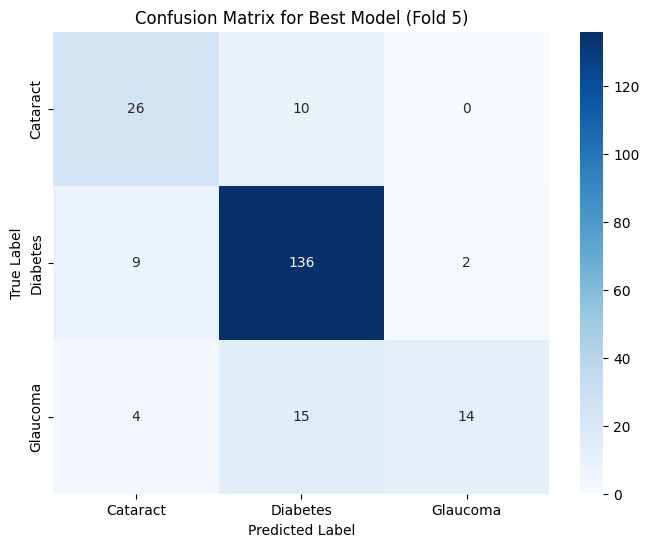





Classification Report for the best model (Fold 5):



              precision    recall  f1-score   support







    Cataract       0.67      0.72      0.69        36



    Diabetes       0.84      0.93      0.88       147



    Glaucoma       0.88      0.42      0.57        33







    accuracy                           0.81       216



   macro avg       0.80      0.69      0.72       216



weighted avg       0.82      0.81      0.80       216







Training and evaluation finished.


In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Updated size here
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 2

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)

## 2.3 Simple CNN with Image size (448 x 448) pixels





Fold 1/5



Train indices count: 865, Validation indices count: 217



Epoch 1:



  -- Training dataset. Claasified 555 out of 865 images to correct labels (64.162%). Epoch loss: 1.229



   - Validation dataset. Claasified 146 out of 217 images to correct labels (67.281%). Epoch loss: 0.825



Epoch 2:



  -- Training dataset. Claasified 576 out of 865 images to correct labels (66.590%). Epoch loss: 0.753



   - Validation dataset. Claasified 150 out of 217 images to correct labels (69.124%). Epoch loss: 0.733



Epoch 3:



  -- Training dataset. Claasified 591 out of 865 images to correct labels (68.324%). Epoch loss: 0.713



   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 1.312



Epoch 4:



  -- Training dataset. Claasified 581 out of 865 images to correct labels (67.168%). Epoch loss: 0.788



   - Validation dataset. Claasified 148 out of 217 images to correct labels (68.203%). Epoch loss: 0.773



Epoch 5:



  -- Trai

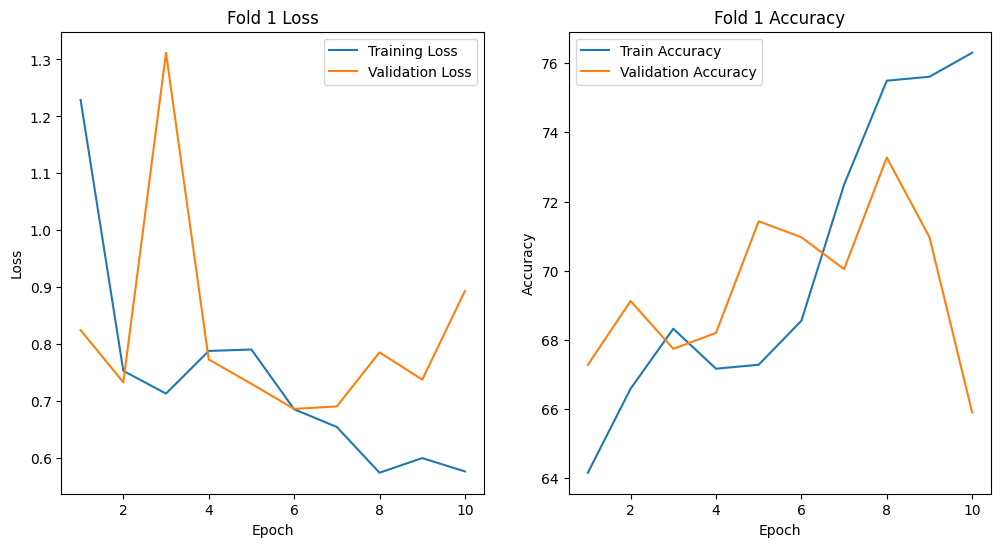

The best Epoch (Epoch 8) of Fold 1:







Classification Report for the Best Epoch (Epoch 8) of Fold 1:



              precision    recall  f1-score   support







    Cataract       0.59      0.48      0.53        42



    Diabetes       0.77      0.93      0.84       147



    Glaucoma       0.50      0.11      0.18        28







    accuracy                           0.73       217



   macro avg       0.62      0.50      0.51       217



weighted avg       0.70      0.73      0.69       217











Fold 2/5



Train indices count: 865, Validation indices count: 217



Epoch 1:



  -- Training dataset. Claasified 522 out of 865 images to correct labels (60.347%). Epoch loss: 1.294



   - Validation dataset. Claasified 155 out of 217 images to correct labels (71.429%). Epoch loss: 0.763



Epoch 2:



  -- Training dataset. Claasified 588 out of 865 images to correct labels (67.977%). Epoch loss: 0.812



   - Validation dataset. Claasified 158 out of 217 images to c

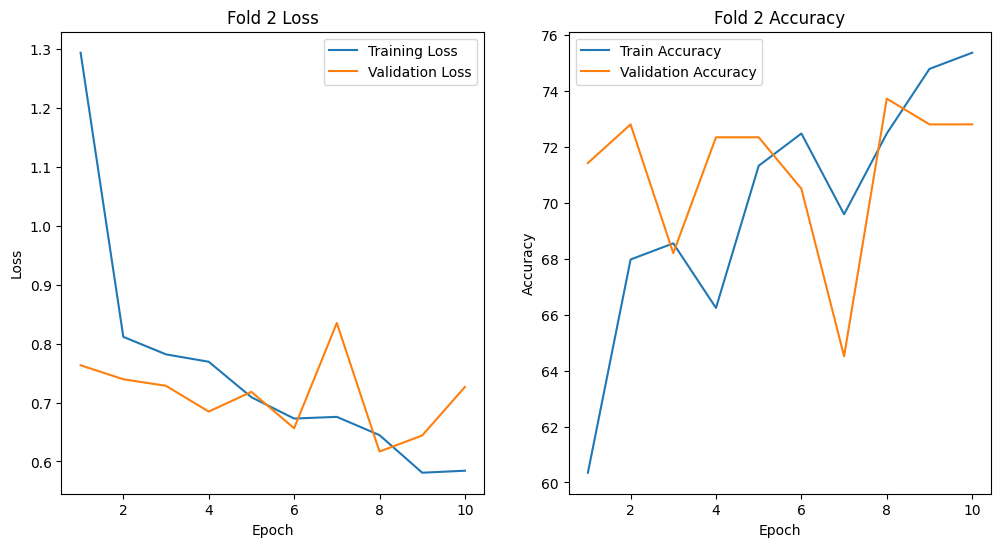

The best Epoch (Epoch 8) of Fold 2:







Classification Report for the Best Epoch (Epoch 8) of Fold 2:



              precision    recall  f1-score   support







    Cataract       0.47      0.46      0.46        35



    Diabetes       0.82      0.89      0.85       154



    Glaucoma       0.44      0.25      0.32        28







    accuracy                           0.74       217



   macro avg       0.58      0.53      0.55       217



weighted avg       0.71      0.74      0.72       217











Fold 3/5



Train indices count: 866, Validation indices count: 216



Epoch 1:



  -- Training dataset. Claasified 526 out of 866 images to correct labels (60.739%). Epoch loss: 1.745



   - Validation dataset. Claasified 134 out of 216 images to correct labels (62.037%). Epoch loss: 0.902



Epoch 2:



  -- Training dataset. Claasified 595 out of 866 images to correct labels (68.707%). Epoch loss: 0.786



   - Validation dataset. Claasified 144 out of 216 images to c

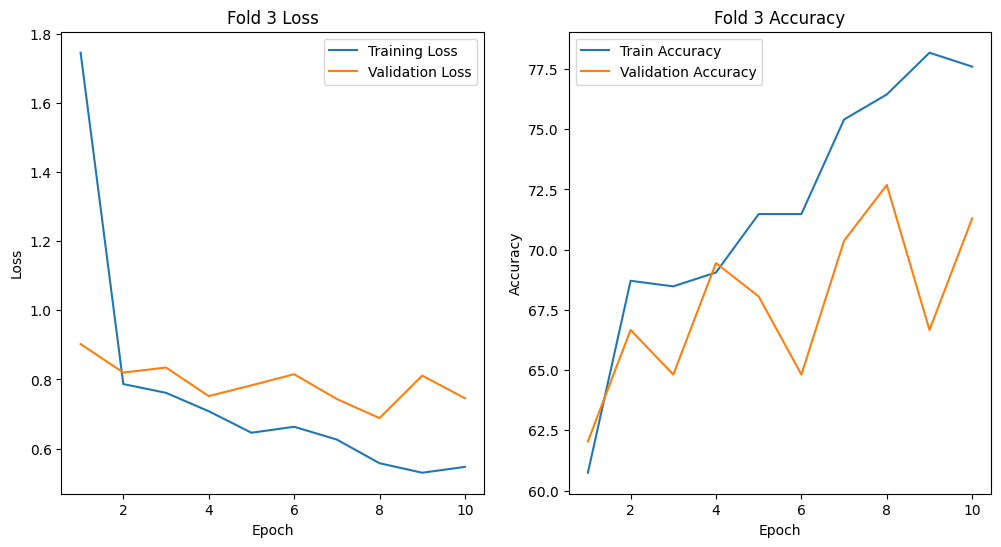

The best Epoch (Epoch 8) of Fold 3:







Classification Report for the Best Epoch (Epoch 8) of Fold 3:



              precision    recall  f1-score   support







    Cataract       0.69      0.49      0.57        51



    Diabetes       0.78      0.87      0.82       132



    Glaucoma       0.52      0.52      0.52        33







    accuracy                           0.73       216



   macro avg       0.66      0.63      0.64       216



weighted avg       0.72      0.73      0.72       216











Fold 4/5



Train indices count: 866, Validation indices count: 216



Epoch 1:



  -- Training dataset. Claasified 539 out of 866 images to correct labels (62.240%). Epoch loss: 1.446



   - Validation dataset. Claasified 135 out of 216 images to correct labels (62.500%). Epoch loss: 0.888



Epoch 2:



  -- Training dataset. Claasified 601 out of 866 images to correct labels (69.400%). Epoch loss: 0.767



   - Validation dataset. Claasified 134 out of 216 images to c

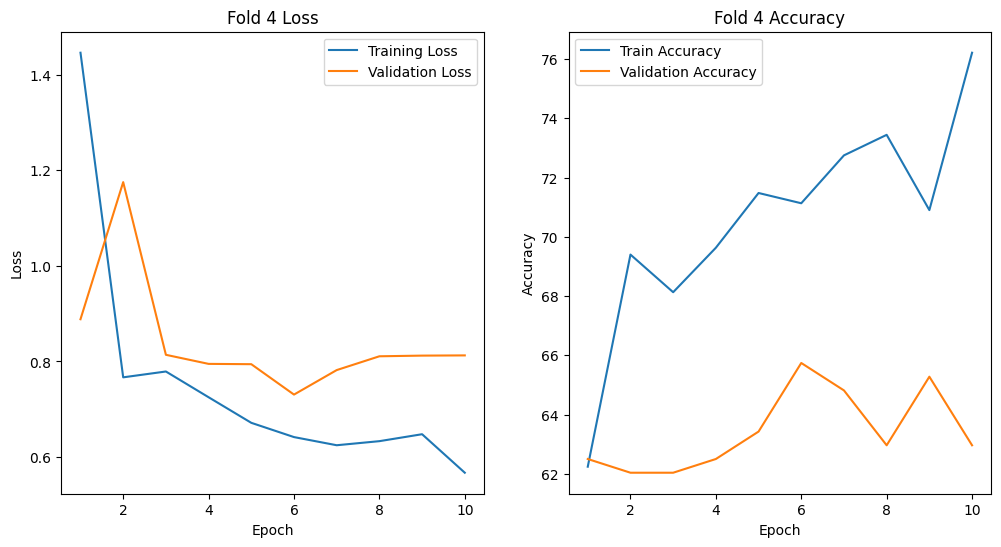

The best Epoch (Epoch 6) of Fold 4:







Classification Report for the Best Epoch (Epoch 6) of Fold 4:



              precision    recall  f1-score   support







    Cataract       0.65      0.28      0.39        46



    Diabetes       0.67      0.95      0.79       132



    Glaucoma       0.40      0.11      0.17        38







    accuracy                           0.66       216



   macro avg       0.57      0.44      0.45       216



weighted avg       0.62      0.66      0.59       216











Fold 5/5



Train indices count: 866, Validation indices count: 216



Epoch 1:



  -- Training dataset. Claasified 556 out of 866 images to correct labels (64.203%). Epoch loss: 1.574



   - Validation dataset. Claasified 145 out of 216 images to correct labels (67.130%). Epoch loss: 0.927



Epoch 2:



  -- Training dataset. Claasified 545 out of 866 images to correct labels (62.933%). Epoch loss: 0.913



   - Validation dataset. Claasified 148 out of 216 images to c

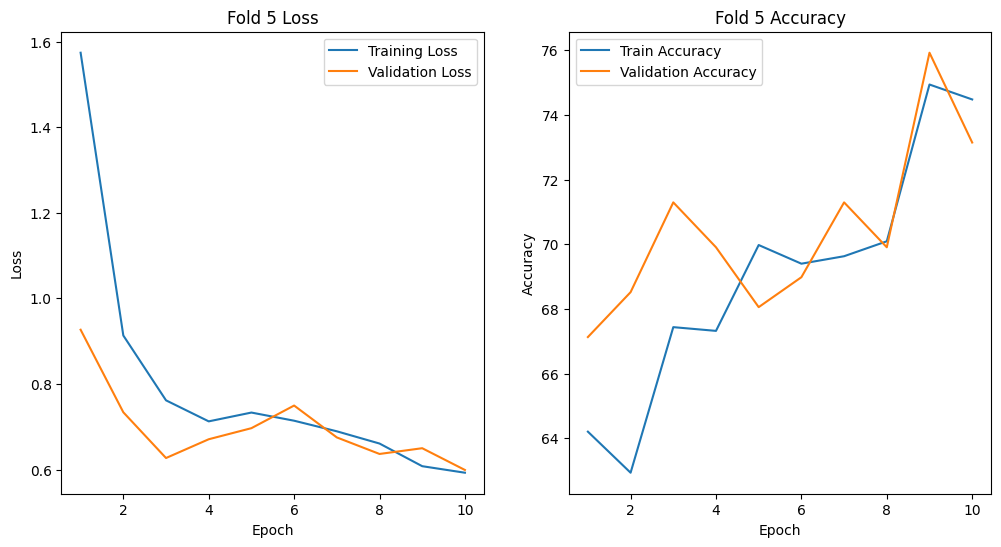

The best Epoch (Epoch 9) of Fold 5:







Classification Report for the Best Epoch (Epoch 9) of Fold 5:



              precision    recall  f1-score   support







    Cataract       0.61      0.61      0.61        36



    Diabetes       0.79      0.93      0.85       147



    Glaucoma       0.83      0.15      0.26        33







    accuracy                           0.76       216



   macro avg       0.74      0.56      0.57       216



weighted avg       0.77      0.76      0.72       216











Best overall model from fold 5 with validation accuracy: 75.93%







Confusion Matrix for the best model (Fold 5):


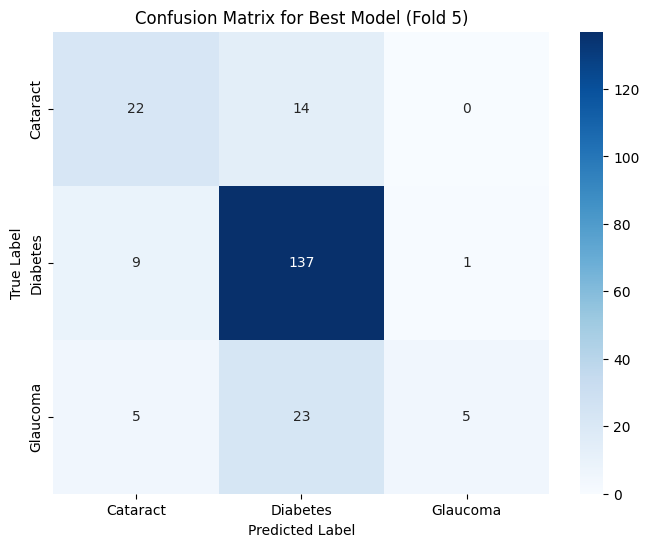





Classification Report for the best model (Fold 5):



              precision    recall  f1-score   support







    Cataract       0.61      0.61      0.61        36



    Diabetes       0.79      0.93      0.85       147



    Glaucoma       0.83      0.15      0.26        33







    accuracy                           0.76       216



   macro avg       0.74      0.56      0.57       216



weighted avg       0.77      0.76      0.72       216







Training and evaluation finished.


In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Update size to 128 * 56 * 56
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor()
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)

# Experiment 3 - CNN with Hyperparameter Tuning


## 3.1 Finding Best Parameters

In [18]:
def train_and_evaluate_cnn_gridcv(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device, param_grid: dict):
    num_classes = len(dataset.classes)
    grid = ParameterGrid(param_grid)

    best_model = None
    best_acc = 0
    best_params = None
    fold_results = []

    # Spliting the dataset into training and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    for params in grid:
        print(f"\nTraining with parameters: {params}")

        # Creating DataLoader with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=4)

        model = SimpleCNN(num_classes=num_classes, dropout_rate=params['dropout_rate']).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        best_epoch_acc = 0.0
        best_epoch = 0
        best_epoch_state = None
        best_epoch_labels = None
        best_epoch_preds = None

        for epoch in range(n_epochs):
            # Training phase
            model.train()
            running_train_loss = 0.0
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

            train_loss = running_train_loss / len(train_loader.dataset)
            train_accuracy = 100 * correct_train / total_train
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validation phase
            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            fold_labels = []
            fold_preds = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)

                    _, predicted = torch.max(outputs.data, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)

                    fold_labels.extend(labels.cpu().numpy())
                    fold_preds.extend(predicted.cpu().numpy())

            val_loss = running_val_loss / len(val_loader.dataset)
            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # Checking for the best epoch
            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Classified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%). Epoch loss: {train_loss:.3f}")
            print(f"   - Validation dataset. Classified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        # Storing the best model and metrics for the current parameter set
        fold_results.append({
            'params': params,
            'val_accuracy': best_epoch_acc,
            'model_state': best_epoch_state,
            'best_epoch': best_epoch + 1,
            'confusion_matrix': confusion_matrix(best_epoch_labels, best_epoch_preds),
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes, zero_division=0)
        })

        if best_epoch_acc > best_acc:
            best_acc = best_epoch_acc
            best_params = params
            best_model = best_epoch_state

        # Plotting the training and validation loss curves
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Loss Curves for Parameters: LR={params["learning_rate"]}, BS={params["batch_size"]}, DR={params["dropout_rate"]}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting the training and validation accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
        plt.title(f'Accuracy Curves for Parameters: LR={params["learning_rate"]}, BS={params["batch_size"]}, DR={params["dropout_rate"]}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

    if best_model:
        torch.save(best_model, f'best_cnn_model_{best_params}_accuracy_{best_acc:.2f}.pth')

    # After the loop over the parameter grid
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])

    # Print statements for the best overall model
    print(f"\nBest Accuracy: {best_overall['val_accuracy']:.2f}%")
    print(f"Best Parameters: {best_overall['params']}")
    print(f"The model in epoch {best_overall['best_epoch']} is the best, with these parameters: {best_overall['params']}")

    # Confusion matrix and classification report for the best epoch with best parameters
    print(f"\nConfusion Matrix for the best epoch (Epoch {best_overall['best_epoch']}) with best parameters:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for Best Epoch (Epoch {best_overall["best_epoch"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best epoch (Epoch {best_overall['best_epoch']}) with best parameters:")
    print(best_overall['classification_report'])

    print(f"\nBest Accuracy: {best_acc:.2f}%")
    print(f"Best Parameters: {best_params}")



Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 0.001}

Epoch 1:

  -- Training dataset. Classified 547 out of 865 images to correct labels (63.237%). Epoch loss: 0.963

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 0.867

Epoch 2:

  -- Training dataset. Classified 586 out of 865 images to correct labels (67.746%). Epoch loss: 0.808

   - Validation dataset. Classified 146 out of 217 images to correct labels (67.281%). Epoch loss: 0.836

Epoch 3:

  -- Training dataset. Classified 601 out of 865 images to correct labels (69.480%). Epoch loss: 0.758

   - Validation dataset. Classified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.727

Epoch 4:

  -- Training dataset. Classified 582 out of 865 images to correct labels (67.283%). Epoch loss: 0.738

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 0.734

Epoch 5:

  -- Training dat

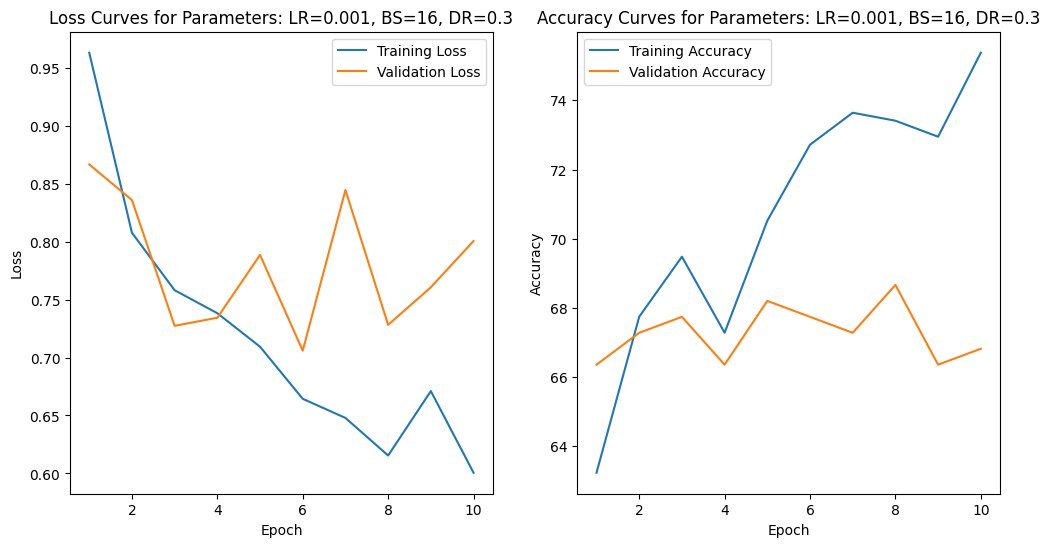



Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 0.01}

Epoch 1:

  -- Training dataset. Classified 528 out of 865 images to correct labels (61.040%). Epoch loss: 3.866

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 0.910

Epoch 2:

  -- Training dataset. Classified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.885

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 0.884

Epoch 3:

  -- Training dataset. Classified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.879

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 0.887

Epoch 4:

  -- Training dataset. Classified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.882

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 0.881

Epoch 5:

  -- Training data

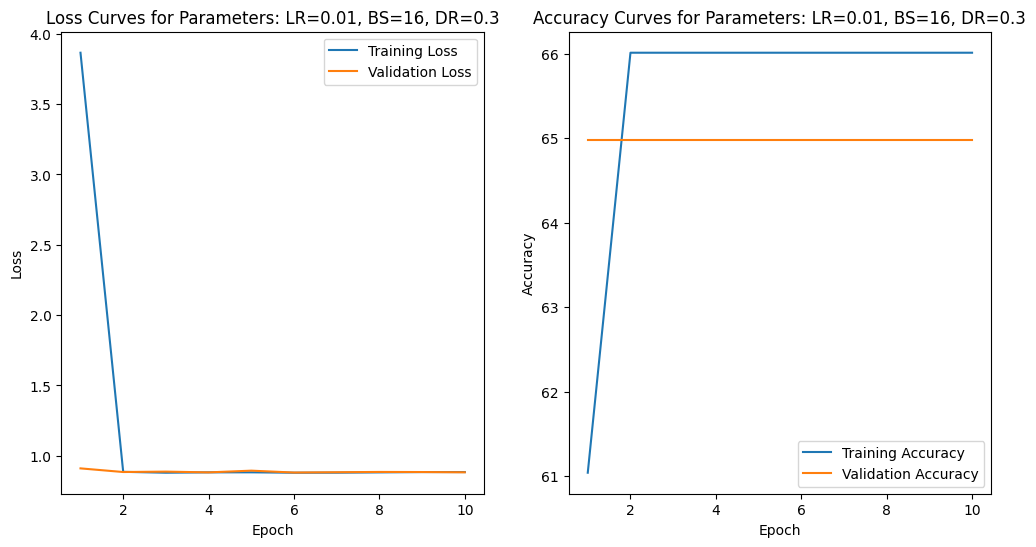



Training with parameters: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 0.001}

Epoch 1:

  -- Training dataset. Classified 556 out of 865 images to correct labels (64.277%). Epoch loss: 0.979

   - Validation dataset. Classified 142 out of 217 images to correct labels (65.438%). Epoch loss: 0.962

Epoch 2:

  -- Training dataset. Classified 590 out of 865 images to correct labels (68.208%). Epoch loss: 0.842

   - Validation dataset. Classified 135 out of 217 images to correct labels (62.212%). Epoch loss: 0.856

Epoch 3:

  -- Training dataset. Classified 588 out of 865 images to correct labels (67.977%). Epoch loss: 0.780

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 0.798

Epoch 4:

  -- Training dataset. Classified 589 out of 865 images to correct labels (68.092%). Epoch loss: 0.781

   - Validation dataset. Classified 135 out of 217 images to correct labels (62.212%). Epoch loss: 0.756

Epoch 5:

  -- Training dat

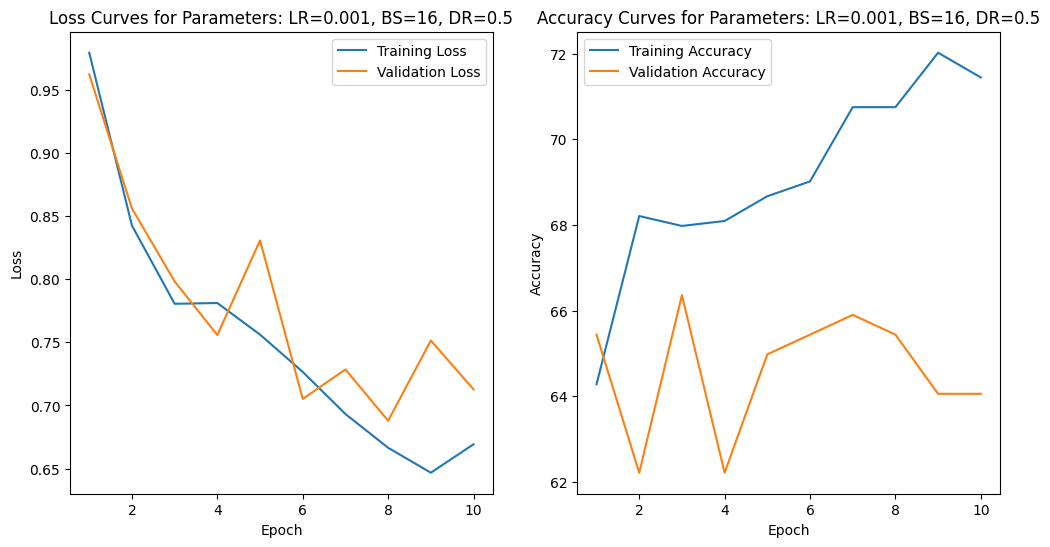



Training with parameters: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 0.01}

Epoch 1:

  -- Training dataset. Classified 546 out of 865 images to correct labels (63.121%). Epoch loss: 7.901

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 0.887

Epoch 2:

  -- Training dataset. Classified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.889

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 0.880

Epoch 3:

  -- Training dataset. Classified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.886

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 0.881

Epoch 4:

  -- Training dataset. Classified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.878

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 0.885

Epoch 5:

  -- Training data

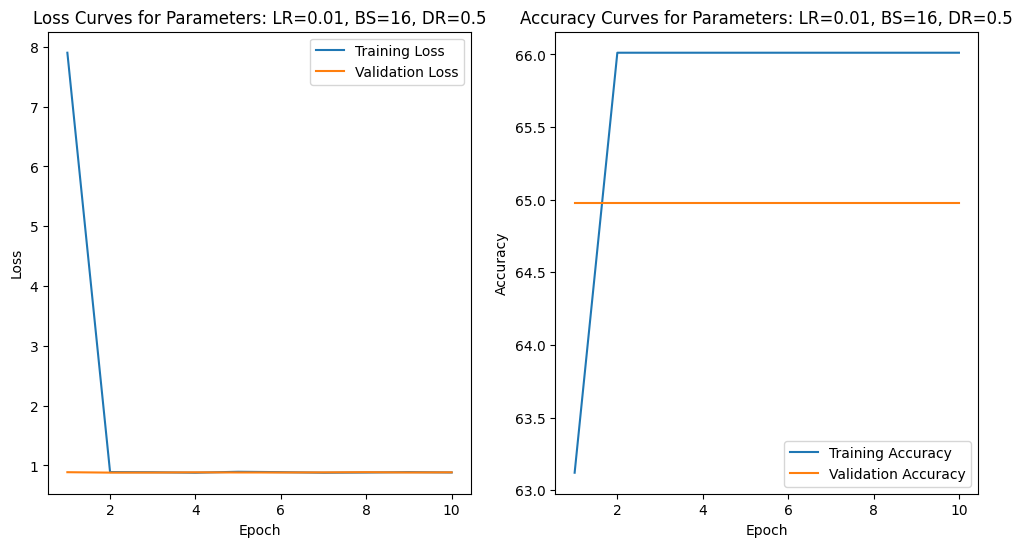



Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001}

Epoch 1:

  -- Training dataset. Classified 550 out of 865 images to correct labels (63.584%). Epoch loss: 0.963

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 0.836

Epoch 2:

  -- Training dataset. Classified 582 out of 865 images to correct labels (67.283%). Epoch loss: 0.828

   - Validation dataset. Classified 139 out of 217 images to correct labels (64.055%). Epoch loss: 0.843

Epoch 3:

  -- Training dataset. Classified 585 out of 865 images to correct labels (67.630%). Epoch loss: 0.815

   - Validation dataset. Classified 139 out of 217 images to correct labels (64.055%). Epoch loss: 0.832

Epoch 4:

  -- Training dataset. Classified 599 out of 865 images to correct labels (69.249%). Epoch loss: 0.758

   - Validation dataset. Classified 142 out of 217 images to correct labels (65.438%). Epoch loss: 0.748

Epoch 5:

  -- Training dat

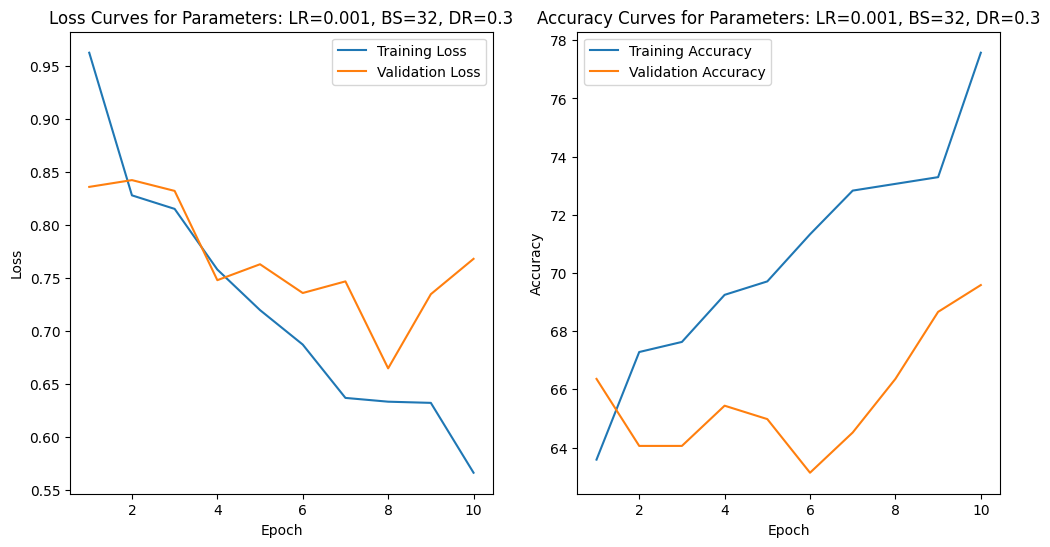



Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01}

Epoch 1:

  -- Training dataset. Classified 500 out of 865 images to correct labels (57.803%). Epoch loss: 14.610

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 1.364

Epoch 2:

  -- Training dataset. Classified 569 out of 865 images to correct labels (65.780%). Epoch loss: 0.896

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 1.131

Epoch 3:

  -- Training dataset. Classified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.897

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 0.865

Epoch 4:

  -- Training dataset. Classified 576 out of 865 images to correct labels (66.590%). Epoch loss: 0.874

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 0.899

Epoch 5:

  -- Training dat

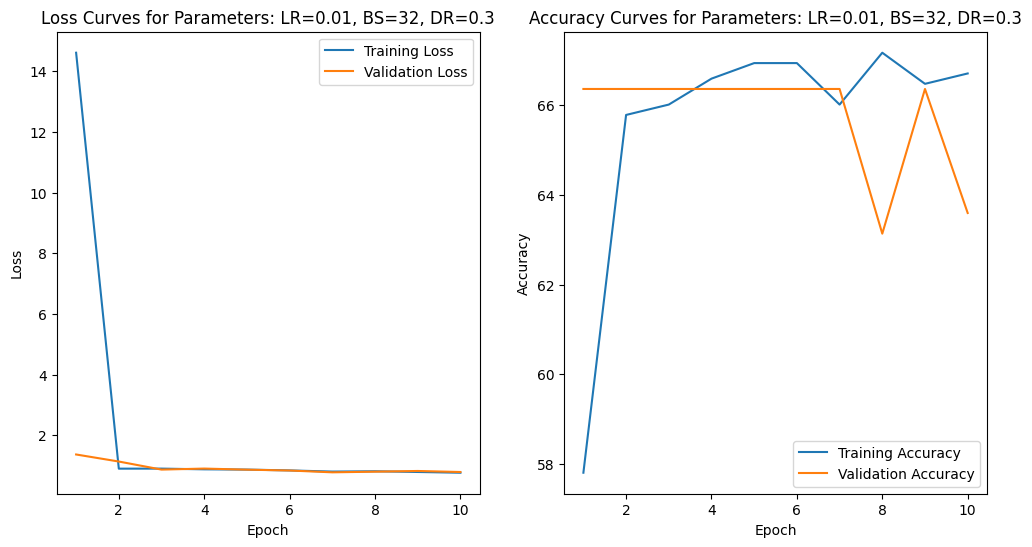



Training with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001}

Epoch 1:

  -- Training dataset. Classified 564 out of 865 images to correct labels (65.202%). Epoch loss: 0.871

   - Validation dataset. Classified 142 out of 217 images to correct labels (65.438%). Epoch loss: 0.798

Epoch 2:

  -- Training dataset. Classified 600 out of 865 images to correct labels (69.364%). Epoch loss: 0.764

   - Validation dataset. Classified 145 out of 217 images to correct labels (66.820%). Epoch loss: 0.742

Epoch 3:

  -- Training dataset. Classified 597 out of 865 images to correct labels (69.017%). Epoch loss: 0.755

   - Validation dataset. Classified 140 out of 217 images to correct labels (64.516%). Epoch loss: 0.785

Epoch 4:

  -- Training dataset. Classified 598 out of 865 images to correct labels (69.133%). Epoch loss: 0.757

   - Validation dataset. Classified 132 out of 217 images to correct labels (60.829%). Epoch loss: 0.882

Epoch 5:

  -- Training dat

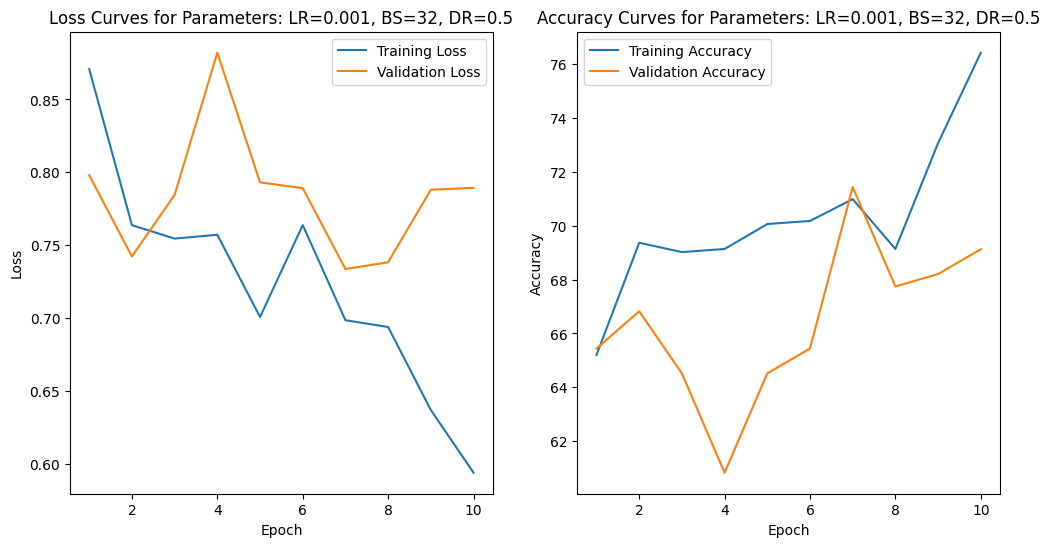



Training with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01}

Epoch 1:

  -- Training dataset. Classified 493 out of 865 images to correct labels (56.994%). Epoch loss: 29.236

   - Validation dataset. Classified 142 out of 217 images to correct labels (65.438%). Epoch loss: 0.903

Epoch 2:

  -- Training dataset. Classified 575 out of 865 images to correct labels (66.474%). Epoch loss: 0.885

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 0.825

Epoch 3:

  -- Training dataset. Classified 566 out of 865 images to correct labels (65.434%). Epoch loss: 0.846

   - Validation dataset. Classified 145 out of 217 images to correct labels (66.820%). Epoch loss: 0.816

Epoch 4:

  -- Training dataset. Classified 567 out of 865 images to correct labels (65.549%). Epoch loss: 0.845

   - Validation dataset. Classified 144 out of 217 images to correct labels (66.359%). Epoch loss: 0.894

Epoch 5:

  -- Training dat

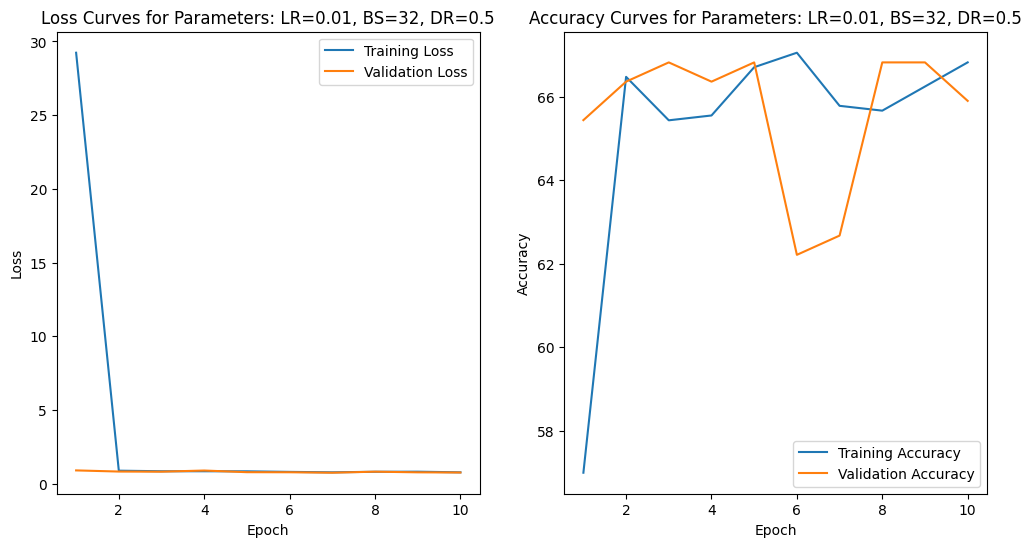



Best Accuracy: 71.43%

Best Parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001}

The model in epoch 7 is the best, with these parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001}



Confusion Matrix for the best epoch (Epoch 7) with best parameters:


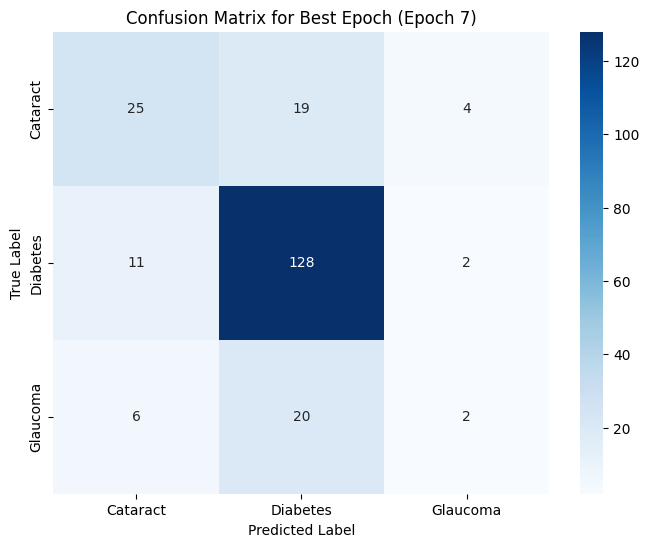



Classification Report for the best epoch (Epoch 7) with best parameters:

              precision    recall  f1-score   support



    Cataract       0.60      0.52      0.56        48

    Diabetes       0.77      0.91      0.83       141

    Glaucoma       0.25      0.07      0.11        28



    accuracy                           0.71       217

   macro avg       0.54      0.50      0.50       217

weighted avg       0.66      0.71      0.68       217





Best Accuracy: 71.43%

Best Parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001}


In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the number of epochs
n_epochs = 10

# Defining the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'dropout_rate': [0.3, 0.5]
}

# Calling the function to train and evaluate the model with grid search
train_and_evaluate_cnn_gridcv(dataset=dataset, n_epochs=10, device=device, param_grid=param_grid)

## 3.2 Training model with Best Parameteres

In [21]:
def train_and_evaluate_cnn_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device,
                                 learning_rate: float = 0.001, dropout_rate: float = 0.5, batch_size: int = 32, k: int = 5):
    num_classes = len(dataset.classes)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    best_model = None
    best_acc = 0
    best_acc_fold = 0
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        # Checking the number of images in each subset
        print(f"Train indices count: {len(train_idx)}, Validation indices count: {len(val_idx)}")

        # Ensuring the subsets are created correctly
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Double-checking that all images are included
        assert len(train_subset) + len(val_subset) == len(dataset), "Subset length mismatch!"

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_acc_history = []
        val_acc_history = []
        epoch_losses = []
        val_losses = []
        best_epoch_labels = []
        best_epoch_preds = []
        
        best_epoch = -1
        best_epoch_acc = 0
        best_epoch_state = None

        for epoch in range(n_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100.0 * correct_train / total_train
            train_acc_history.append(train_accuracy)
            epoch_loss = running_loss / total_train
            epoch_losses.append(epoch_loss)

            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            fold_labels = []
            fold_preds = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    fold_labels.extend(labels.cpu().numpy())
                    fold_preds.extend(predicted.cpu().numpy())

            val_accuracy = 100.0 * correct_val / total_val
            val_acc_history.append(val_accuracy)
            val_loss = running_val_loss / total_val
            val_losses.append(val_loss)

            # Tracking the best epoch within this fold
            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Classified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Classified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds)
        print(f"The best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1} with parameters:")
        print(f"  - Batch Size: {batch_size}")
        print(f"  - Dropout Rate: {dropout_rate}")
        print(f"  - Learning Rate: {learning_rate}")

        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes),
            'parameters': {
                'batch_size': batch_size,
                'dropout_rate': dropout_rate,
                'learning_rate': learning_rate
            }
        })

        if best_epoch_acc > best_acc:
            best_acc = best_epoch_acc
            best_acc_fold = fold + 1
            best_model = best_epoch_state

    if best_model:
        # Saving the best model across all folds with hyperparameters
        torch.save(best_model, f'best_cnn_model_fold_{best_acc_fold}_accuracy_{best_acc:.2f}_batch_{batch_size}_dropout_{dropout_rate}_lr_{learning_rate}.pth')

    # Comparing all best models and printing the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")
    
    # Printing confusion matrix and classification report for the best overall model
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    # Saving the best overall model with hyperparameters
    torch.save(best_overall['model_state'], f'best_overall_cnn_model_fold_{best_overall["fold"]}_accuracy_{best_overall["val_accuracy"]:.2f}_batch_{batch_size}_dropout_{dropout_rate}_lr_{learning_rate}.pth')

    print("Training and evaluation finished.")




Fold 1/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Classified 560 out of 865 images to correct labels (64.740%). Epoch loss: 0.920

   - Validation dataset. Classified 153 out of 217 images to correct labels (70.507%). Epoch loss: 0.730

Epoch 2:

  -- Training dataset. Classified 590 out of 865 images to correct labels (68.208%). Epoch loss: 0.770

   - Validation dataset. Classified 151 out of 217 images to correct labels (69.585%). Epoch loss: 0.690

Epoch 3:

  -- Training dataset. Classified 582 out of 865 images to correct labels (67.283%). Epoch loss: 0.758

   - Validation dataset. Classified 161 out of 217 images to correct labels (74.194%). Epoch loss: 0.723

Epoch 4:

  -- Training dataset. Classified 578 out of 865 images to correct labels (66.821%). Epoch loss: 0.746

   - Validation dataset. Classified 154 out of 217 images to correct labels (70.968%). Epoch loss: 0.680

Epoch 5:

  -- Training dataset. Classified 605 out

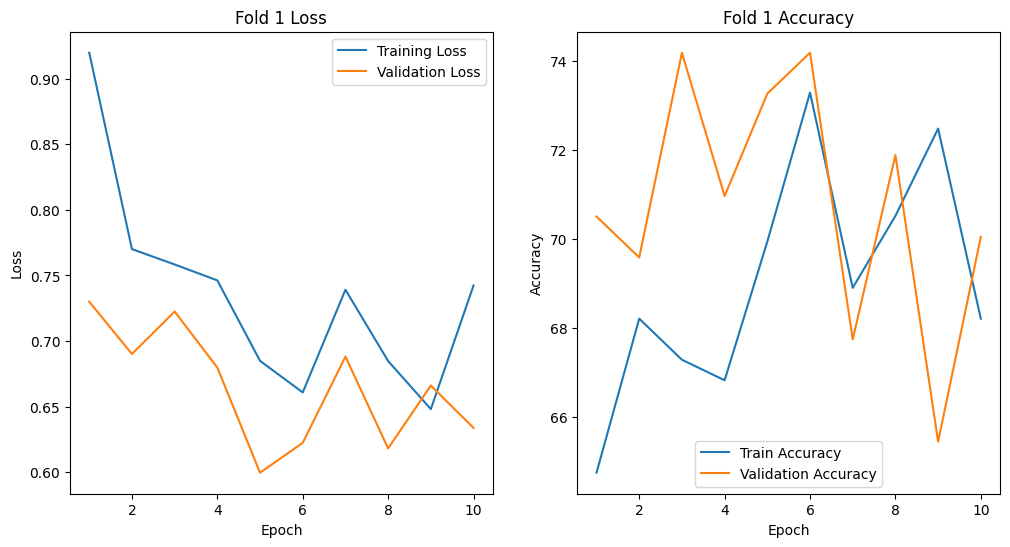

The best Epoch (Epoch 3) of Fold 1 with parameters:

  - Batch Size: 32

  - Dropout Rate: 0.5

  - Learning Rate: 0.001



Classification Report for the Best Epoch (Epoch 3) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.56      0.52      0.54        42

    Diabetes       0.83      0.86      0.85       147

    Glaucoma       0.48      0.46      0.47        28



    accuracy                           0.74       217

   macro avg       0.63      0.62      0.62       217

weighted avg       0.74      0.74      0.74       217





Fold 2/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Classified 534 out of 865 images to correct labels (61.734%). Epoch loss: 1.016

   - Validation dataset. Classified 154 out of 217 images to correct labels (70.968%). Epoch loss: 0.841

Epoch 2:

  -- Training dataset. Classified 573 out of 865 images to correct labels (66.243%). Epoch loss: 0.845

   - Validation dat

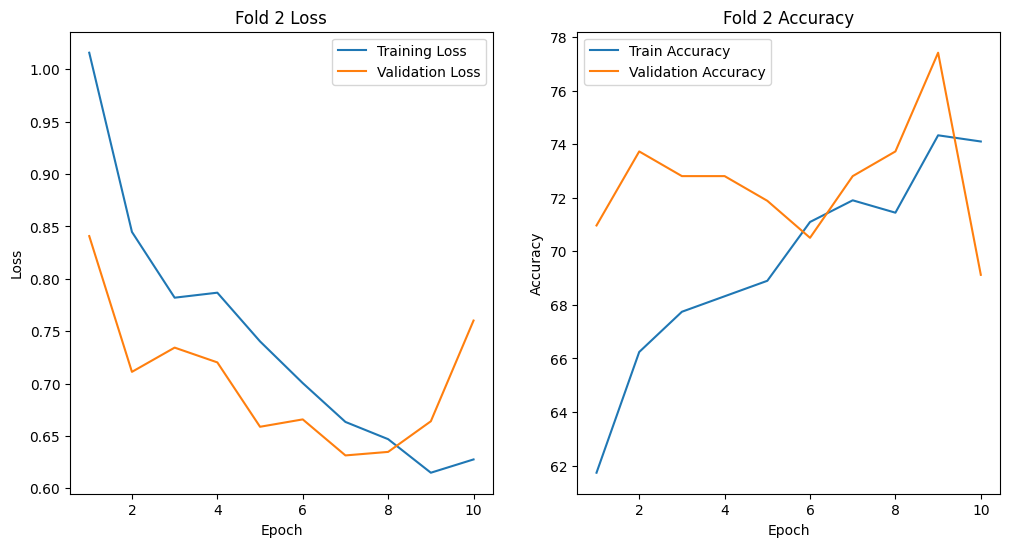

The best Epoch (Epoch 9) of Fold 2 with parameters:

  - Batch Size: 32

  - Dropout Rate: 0.5

  - Learning Rate: 0.001



Classification Report for the Best Epoch (Epoch 9) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.62      0.43      0.51        35

    Diabetes       0.80      0.95      0.87       154

    Glaucoma       0.60      0.21      0.32        28



    accuracy                           0.77       217

   macro avg       0.68      0.53      0.57       217

weighted avg       0.75      0.77      0.74       217





Fold 3/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 537 out of 866 images to correct labels (62.009%). Epoch loss: 0.998

   - Validation dataset. Classified 133 out of 216 images to correct labels (61.574%). Epoch loss: 1.118

Epoch 2:

  -- Training dataset. Classified 593 out of 866 images to correct labels (68.476%). Epoch loss: 0.807

   - Validation dat

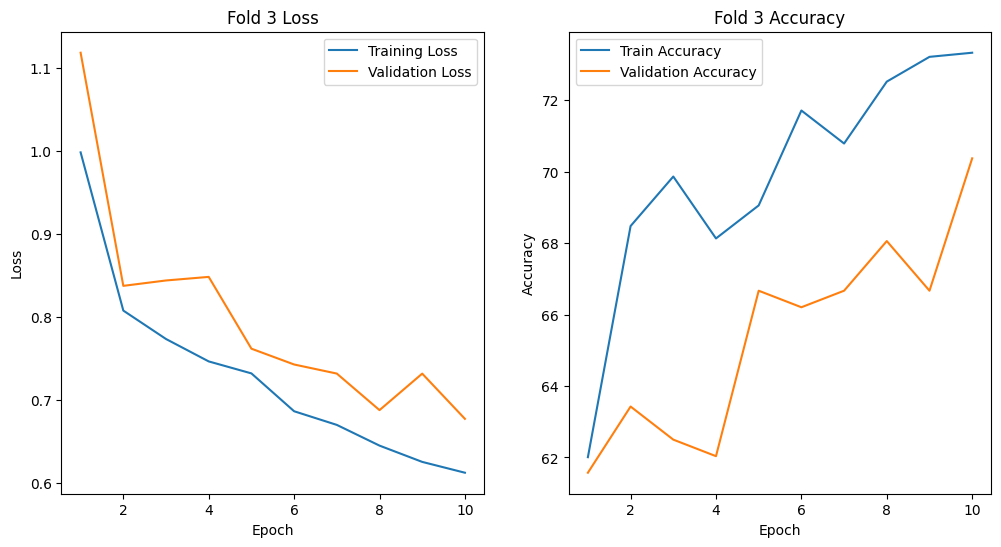

The best Epoch (Epoch 10) of Fold 3 with parameters:

  - Batch Size: 32

  - Dropout Rate: 0.5

  - Learning Rate: 0.001



Classification Report for the Best Epoch (Epoch 10) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.80      0.31      0.45        51

    Diabetes       0.72      0.95      0.82       132

    Glaucoma       0.50      0.33      0.40        33



    accuracy                           0.70       216

   macro avg       0.67      0.53      0.56       216

weighted avg       0.70      0.70      0.67       216





Fold 4/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 526 out of 866 images to correct labels (60.739%). Epoch loss: 1.063

   - Validation dataset. Classified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.905

Epoch 2:

  -- Training dataset. Classified 576 out of 866 images to correct labels (66.513%). Epoch loss: 0.845

   - Validation d

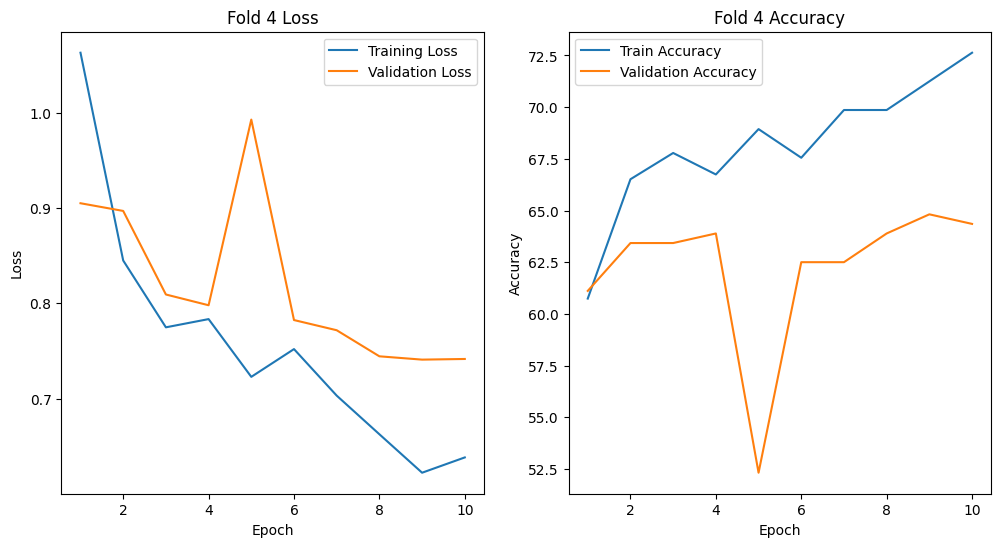

The best Epoch (Epoch 9) of Fold 4 with parameters:

  - Batch Size: 32

  - Dropout Rate: 0.5

  - Learning Rate: 0.001



Classification Report for the Best Epoch (Epoch 9) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.53      0.46      0.49        46

    Diabetes       0.68      0.89      0.77       132

    Glaucoma       0.50      0.03      0.05        38



    accuracy                           0.65       216

   macro avg       0.57      0.46      0.44       216

weighted avg       0.61      0.65      0.58       216





Fold 5/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 547 out of 866 images to correct labels (63.164%). Epoch loss: 0.919

   - Validation dataset. Classified 149 out of 216 images to correct labels (68.981%). Epoch loss: 0.839

Epoch 2:

  -- Training dataset. Classified 586 out of 866 images to correct labels (67.667%). Epoch loss: 0.793

   - Validation dat

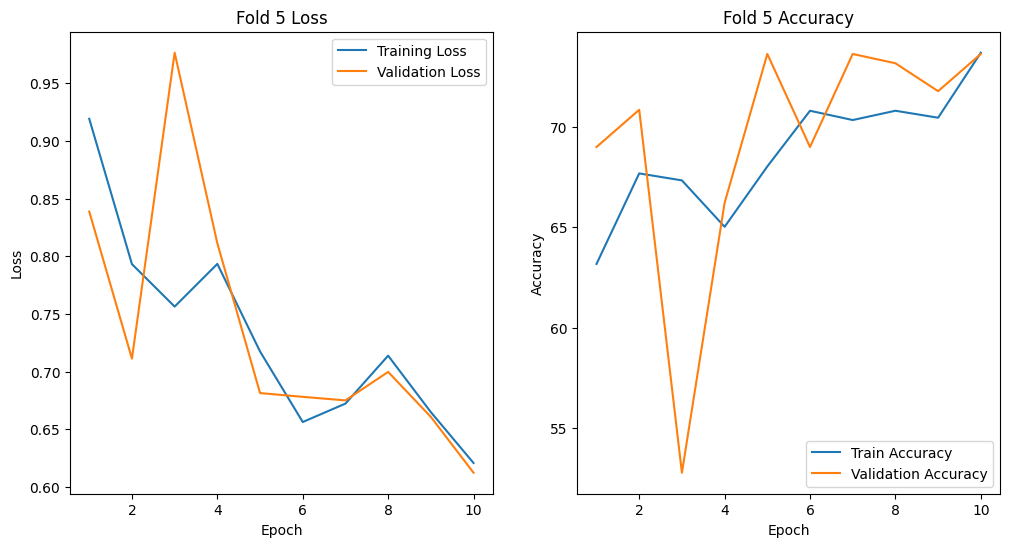

The best Epoch (Epoch 5) of Fold 5 with parameters:

  - Batch Size: 32

  - Dropout Rate: 0.5

  - Learning Rate: 0.001



Classification Report for the Best Epoch (Epoch 5) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.87      0.36      0.51        36

    Diabetes       0.75      0.97      0.85       147

    Glaucoma       0.27      0.09      0.14        33



    accuracy                           0.74       216

   macro avg       0.63      0.47      0.50       216

weighted avg       0.70      0.74      0.68       216





Best overall model from fold 2 with validation accuracy: 77.42%



Confusion Matrix for the best model (Fold 2):


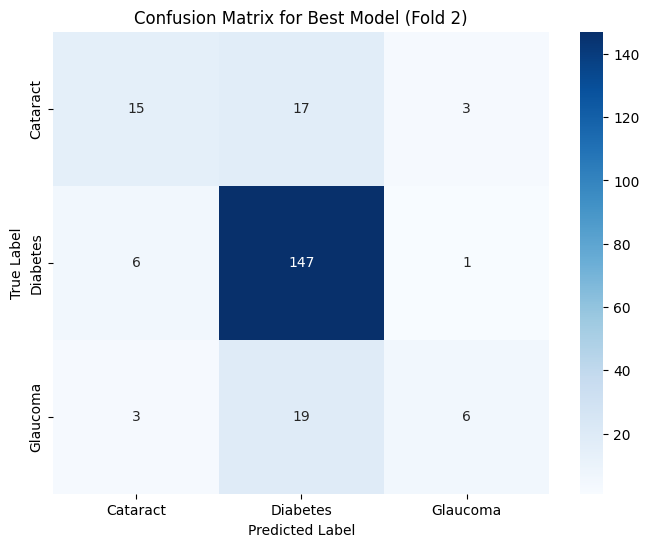



Classification Report for the best model (Fold 2):

              precision    recall  f1-score   support



    Cataract       0.62      0.43      0.51        35

    Diabetes       0.80      0.95      0.87       154

    Glaucoma       0.60      0.21      0.32        28



    accuracy                           0.77       217

   macro avg       0.68      0.53      0.57       217

weighted avg       0.75      0.77      0.74       217



Training and evaluation finished.


In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x
    
    
# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)


# Experiment 4 - ResNet50 (pre-trained model)

#### Resnet50 is one of the baseline pretrained model, which performs good with smaller set of images.

In [23]:
def train_and_evaluate_resnet_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device, k: int = 5):
    num_classes = len(dataset.classes)  # Getting the number of classes from the dataset
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Initializing K-fold cross-validation

    best_model = None 
    best_acc = 0  
    best_acc_fold = 0  
    fold_results = []  

    # Iterating through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        # Creating data loaders for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

        # Loading the pre-trained ResNet50 model
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features  
        model.fc = nn.Linear(in_features, num_classes)  
        model = model.to(device)  
        criterion = nn.CrossEntropyLoss()  

        # Defining the optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_acc_history = []  
        val_acc_history = []  
        epoch_losses = []  
        val_losses = []  
        best_epoch_labels = []  
        best_epoch_preds = []  

        best_epoch = -1  
        best_epoch_acc = 0  
        best_epoch_state = None  

        # Iterating through each epoch
        for epoch in range(n_epochs):
            model.train()  
            running_loss = 0.0  
            correct_train = 0  
            total_train = 0  

            # Iterating through the training data
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)  
                
                # Resetting the gradients
                optimizer.zero_grad()  
                outputs = model(images)  
                loss = criterion(outputs, labels)  
                loss.backward()  
                optimizer.step()

                running_loss += loss.item() * images.size(0)  
                _, predicted = torch.max(outputs, 1)  
                total_train += labels.size(0) 
                correct_train += (predicted == labels).sum().item()  

            train_accuracy = 100.0 * correct_train / total_train  
            train_acc_history.append(train_accuracy)  
            epoch_loss = running_loss / total_train
            # Storing the training loss
            epoch_losses.append(epoch_loss)  

            # Validating phase
            model.eval()  
            running_val_loss = 0.0  
            correct_val = 0  
            total_val = 0 
            fold_labels = []  
            fold_preds = [] 

            # Disabling gradient computation
            with torch.no_grad():
                # Iterating through the validation data
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)  
                    outputs = model(images)  
                    loss = criterion(outputs, labels)  
                    running_val_loss += loss.item() * images.size(0) 
                    _, predicted = torch.max(outputs, 1) 
                    total_val += labels.size(0)  
                    correct_val += (predicted == labels).sum().item()  
                    fold_labels.extend(labels.cpu().numpy()) 
                    fold_preds.extend(predicted.cpu().numpy()) 

            val_accuracy = 100.0 * correct_val / total_val  
            val_acc_history.append(val_accuracy) 
            val_loss = running_val_loss / total_val 
            val_losses.append(val_loss)  

            # Checking if the current epoch has the best accuracy
            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()  
                best_epoch_labels = fold_labels.copy() 
                best_epoch_preds = fold_preds.copy() 

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Classified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Classified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        # Plotting loss metrics for this fold
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting accuracy metrics for this fold
        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plotting confusion matrix for the best epoch of this fold
        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds, labels=list(range(num_classes)))

        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        # Saving the best model of this fold if it has the highest validation accuracy
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_acc_fold = fold
            best_model = best_epoch_state

        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes)
        })

    # Saving the best model after all folds
    if best_model:
        torch.save(best_model, f'resnet_ims448_model_fold_{best_acc_fold + 1}_accuracy_{best_acc:.2f}.pth')

    # Comparing all best models and printing the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")

    # Printing confusion matrix and classification report for the best overall model
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix - Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    print("\nTraining and evaluation finished.")


## 4.1 ResNet with Image size (128 x 128) pixels



Fold 1/5


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s] 


Epoch 1:

  -- Training dataset. Classified 674 out of 865 images to correct labels (77.919%). Epoch loss: 0.624

   - Validation dataset. Classified 59 out of 217 images to correct labels (27.189%). Epoch loss: 11.992

Epoch 2:

  -- Training dataset. Classified 719 out of 865 images to correct labels (83.121%). Epoch loss: 0.475

   - Validation dataset. Classified 186 out of 217 images to correct labels (85.714%). Epoch loss: 0.393

Epoch 3:

  -- Training dataset. Classified 762 out of 865 images to correct labels (88.092%). Epoch loss: 0.352

   - Validation dataset. Classified 168 out of 217 images to correct labels (77.419%). Epoch loss: 1.636

Epoch 4:

  -- Training dataset. Classified 769 out of 865 images to correct labels (88.902%). Epoch loss: 0.322

   - Validation dataset. Classified 176 out of 217 images to correct labels (81.106%). Epoch loss: 0.667

Epoch 5:

  -- Training dataset. Classified 790 out of 865 images to correct labels (91.329%). Epoch loss: 0.273

   - V

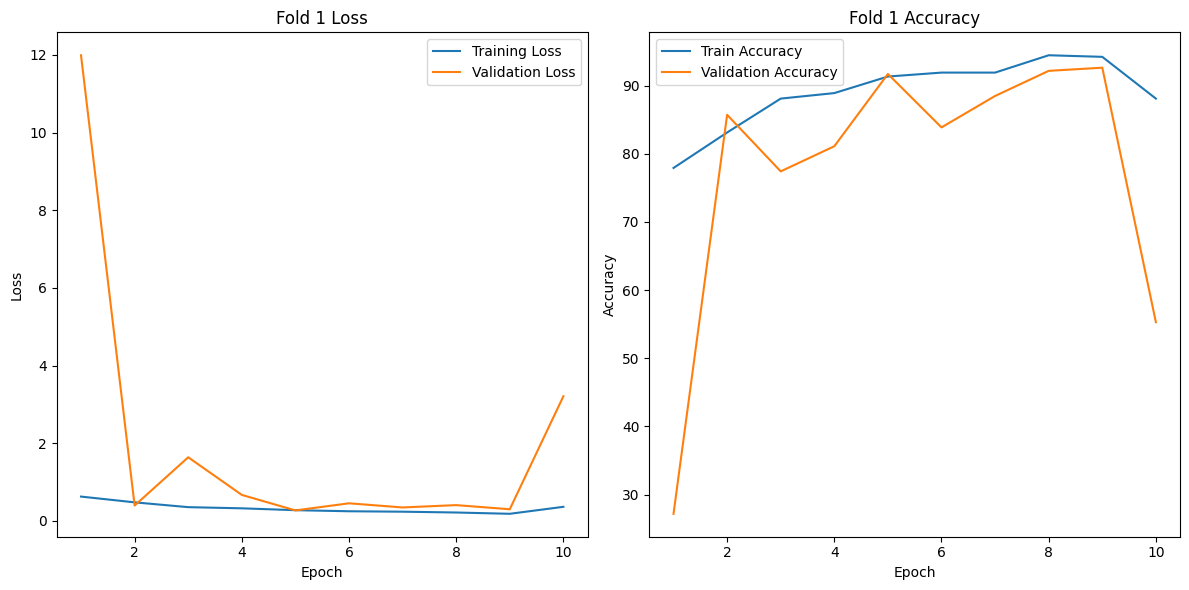



Classification Report for the Best Epoch (Epoch 9) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.93      0.93      0.93        42

    Diabetes       0.93      0.97      0.95       147

    Glaucoma       0.87      0.71      0.78        28



    accuracy                           0.93       217

   macro avg       0.91      0.87      0.89       217

weighted avg       0.92      0.93      0.92       217





Fold 2/5

Epoch 1:

  -- Training dataset. Classified 628 out of 865 images to correct labels (72.601%). Epoch loss: 0.768

   - Validation dataset. Classified 161 out of 217 images to correct labels (74.194%). Epoch loss: 4.903

Epoch 2:

  -- Training dataset. Classified 704 out of 865 images to correct labels (81.387%). Epoch loss: 0.469

   - Validation dataset. Classified 185 out of 217 images to correct labels (85.253%). Epoch loss: 0.460

Epoch 3:

  -- Training dataset. Classified 740 out of 865 images to correct labels (85.549%

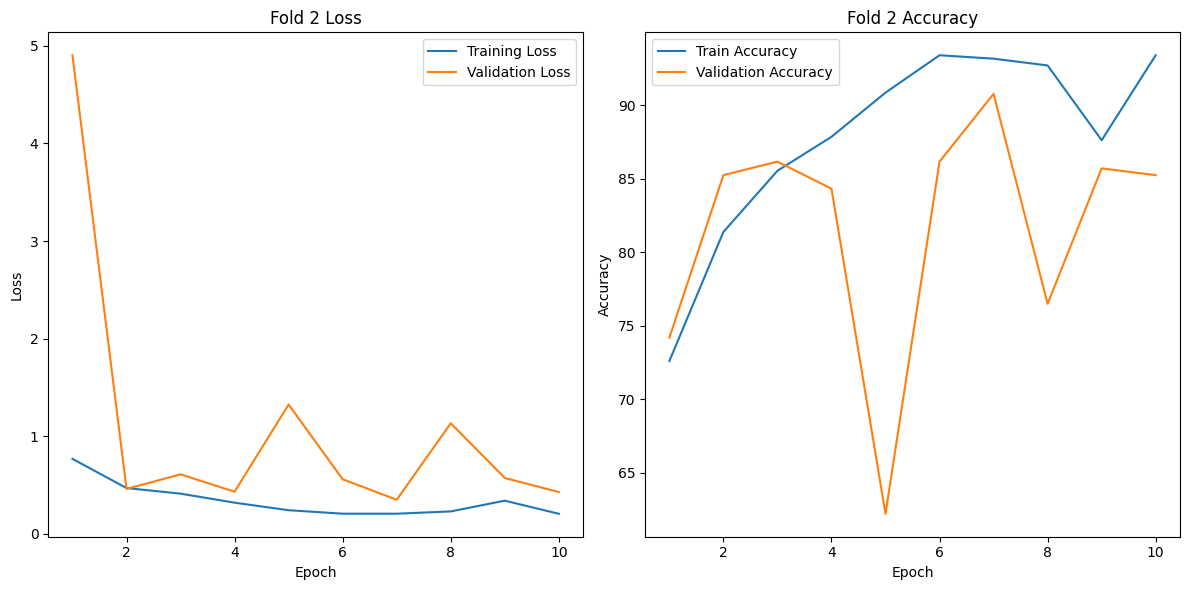



Classification Report for the Best Epoch (Epoch 7) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.94      0.86      0.90        35

    Diabetes       0.90      0.97      0.94       154

    Glaucoma       0.89      0.61      0.72        28



    accuracy                           0.91       217

   macro avg       0.91      0.81      0.85       217

weighted avg       0.91      0.91      0.90       217





Fold 3/5

Epoch 1:

  -- Training dataset. Classified 611 out of 866 images to correct labels (70.554%). Epoch loss: 0.780

   - Validation dataset. Classified 145 out of 216 images to correct labels (67.130%). Epoch loss: 25.245

Epoch 2:

  -- Training dataset. Classified 716 out of 866 images to correct labels (82.679%). Epoch loss: 0.429

   - Validation dataset. Classified 139 out of 216 images to correct labels (64.352%). Epoch loss: 1.191

Epoch 3:

  -- Training dataset. Classified 747 out of 866 images to correct labels (86.259

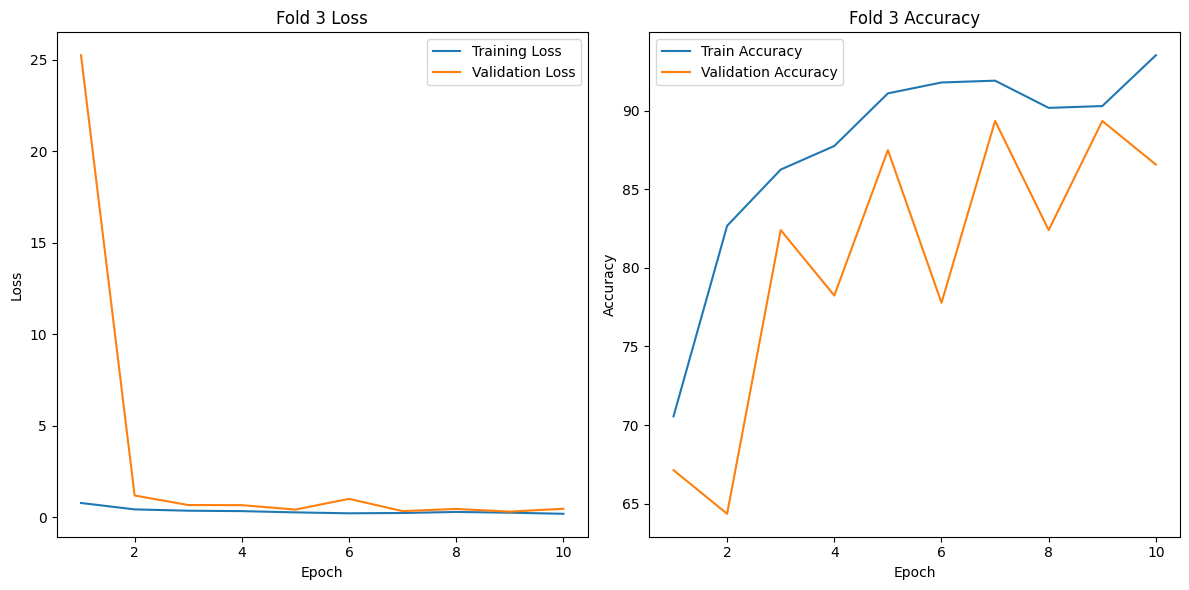



Classification Report for the Best Epoch (Epoch 7) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.98      0.90      0.94        51

    Diabetes       0.91      0.94      0.93       132

    Glaucoma       0.70      0.70      0.70        33



    accuracy                           0.89       216

   macro avg       0.86      0.85      0.85       216

weighted avg       0.89      0.89      0.89       216





Fold 4/5

Epoch 1:

  -- Training dataset. Classified 677 out of 866 images to correct labels (78.176%). Epoch loss: 0.641

   - Validation dataset. Classified 121 out of 216 images to correct labels (56.019%). Epoch loss: 5.146

Epoch 2:

  -- Training dataset. Classified 739 out of 866 images to correct labels (85.335%). Epoch loss: 0.400

   - Validation dataset. Classified 177 out of 216 images to correct labels (81.944%). Epoch loss: 0.566

Epoch 3:

  -- Training dataset. Classified 762 out of 866 images to correct labels (87.991%

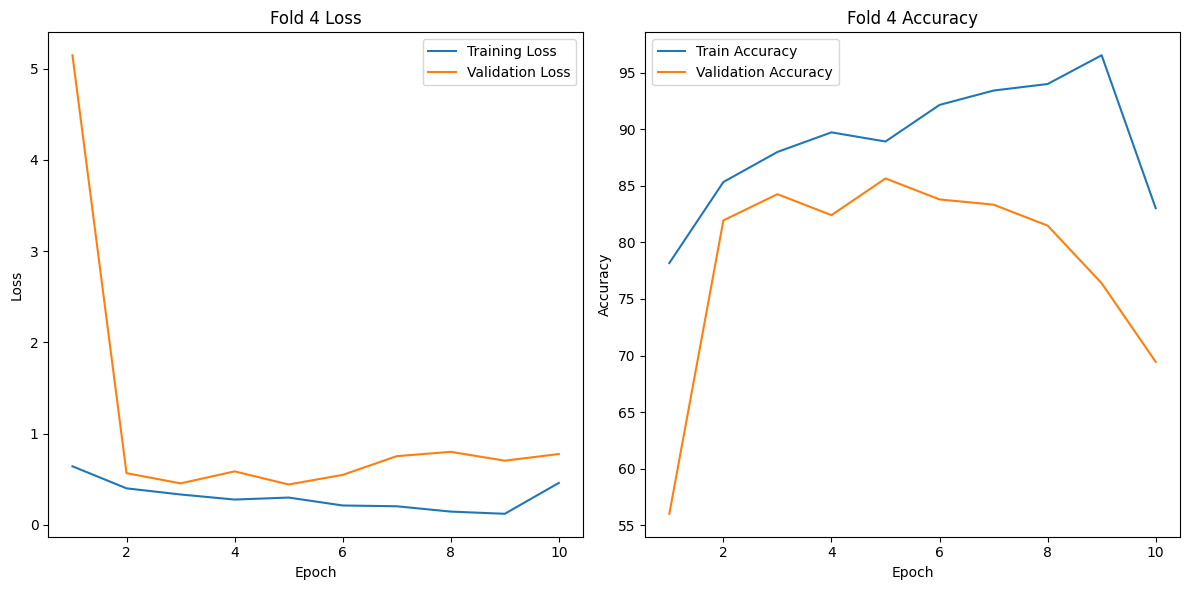



Classification Report for the Best Epoch (Epoch 5) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.84      0.93      0.89        46

    Diabetes       0.89      0.92      0.91       132

    Glaucoma       0.71      0.53      0.61        38



    accuracy                           0.86       216

   macro avg       0.82      0.80      0.80       216

weighted avg       0.85      0.86      0.85       216





Fold 5/5

Epoch 1:

  -- Training dataset. Classified 667 out of 866 images to correct labels (77.021%). Epoch loss: 0.644

   - Validation dataset. Classified 67 out of 216 images to correct labels (31.019%). Epoch loss: 3.294

Epoch 2:

  -- Training dataset. Classified 683 out of 866 images to correct labels (78.868%). Epoch loss: 0.614

   - Validation dataset. Classified 154 out of 216 images to correct labels (71.296%). Epoch loss: 0.888

Epoch 3:

  -- Training dataset. Classified 757 out of 866 images to correct labels (87.413%)

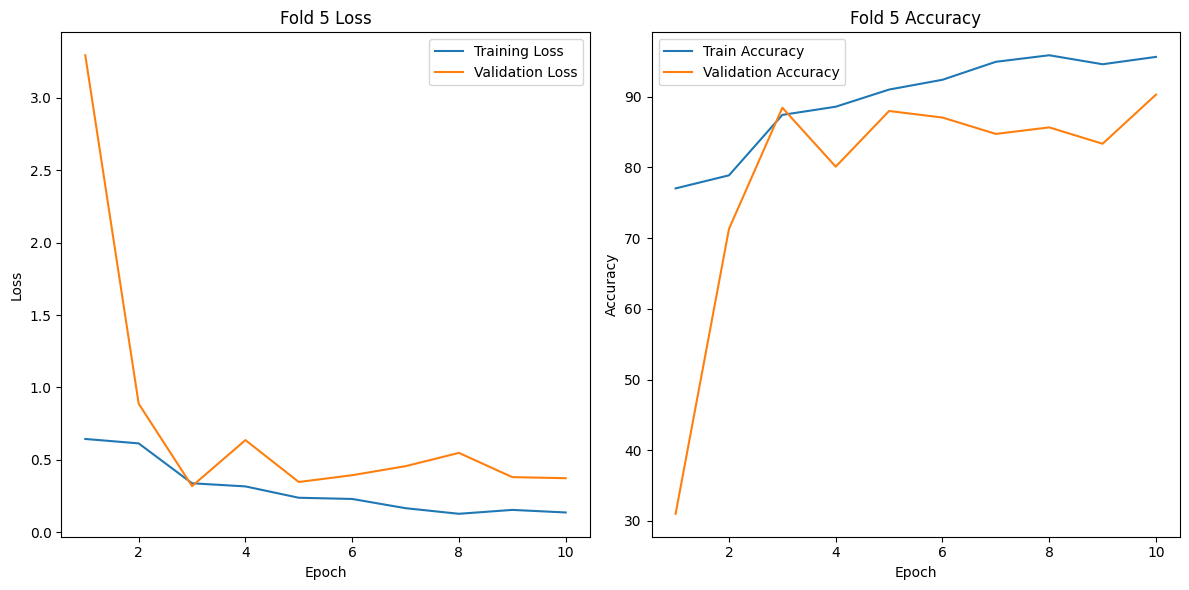



Classification Report for the Best Epoch (Epoch 10) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.92      0.97      0.95        36

    Diabetes       0.94      0.93      0.93       147

    Glaucoma       0.73      0.73      0.73        33



    accuracy                           0.90       216

   macro avg       0.86      0.87      0.87       216

weighted avg       0.90      0.90      0.90       216





Best overall model from fold 1 with validation accuracy: 92.63%



Confusion Matrix for the best model (Fold 1):


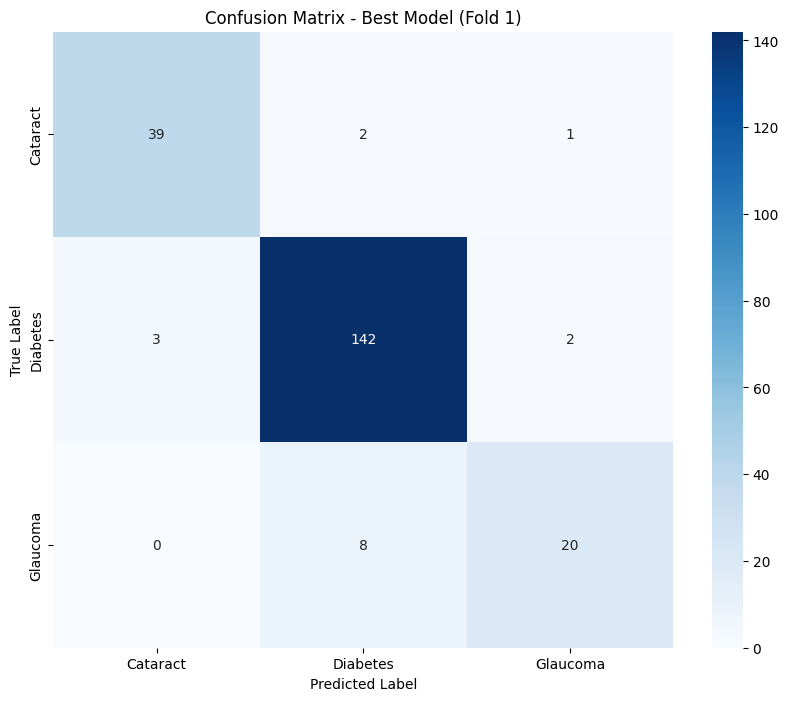



Classification Report for the best model (Fold 1):

              precision    recall  f1-score   support



    Cataract       0.93      0.93      0.93        42

    Diabetes       0.93      0.97      0.95       147

    Glaucoma       0.87      0.71      0.78        28



    accuracy                           0.93       217

   macro avg       0.91      0.87      0.89       217

weighted avg       0.92      0.93      0.92       217





Training and evaluation finished.


In [24]:
# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing images to 128x128
    transforms.ToTensor(),  # Converting images to tensors
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform) 

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10  
k = 5 

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k) 

## 4.2 ResNet with Image size (224 x 224) pixels



Fold 1/5

Epoch 1:

  -- Training dataset. Classified 649 out of 865 images to correct labels (75.029%). Epoch loss: 0.634

   - Validation dataset. Classified 138 out of 217 images to correct labels (63.594%). Epoch loss: 1.437

Epoch 2:

  -- Training dataset. Classified 717 out of 865 images to correct labels (82.890%). Epoch loss: 0.481

   - Validation dataset. Classified 131 out of 217 images to correct labels (60.369%). Epoch loss: 1.360

Epoch 3:

  -- Training dataset. Classified 741 out of 865 images to correct labels (85.665%). Epoch loss: 0.408

   - Validation dataset. Classified 130 out of 217 images to correct labels (59.908%). Epoch loss: 1.705

Epoch 4:

  -- Training dataset. Classified 788 out of 865 images to correct labels (91.098%). Epoch loss: 0.281

   - Validation dataset. Classified 165 out of 217 images to correct labels (76.037%). Epoch loss: 0.801

Epoch 5:

  -- Training dataset. Classified 788 out of 865 images to correct labels (91.098%). Epoch loss: 0

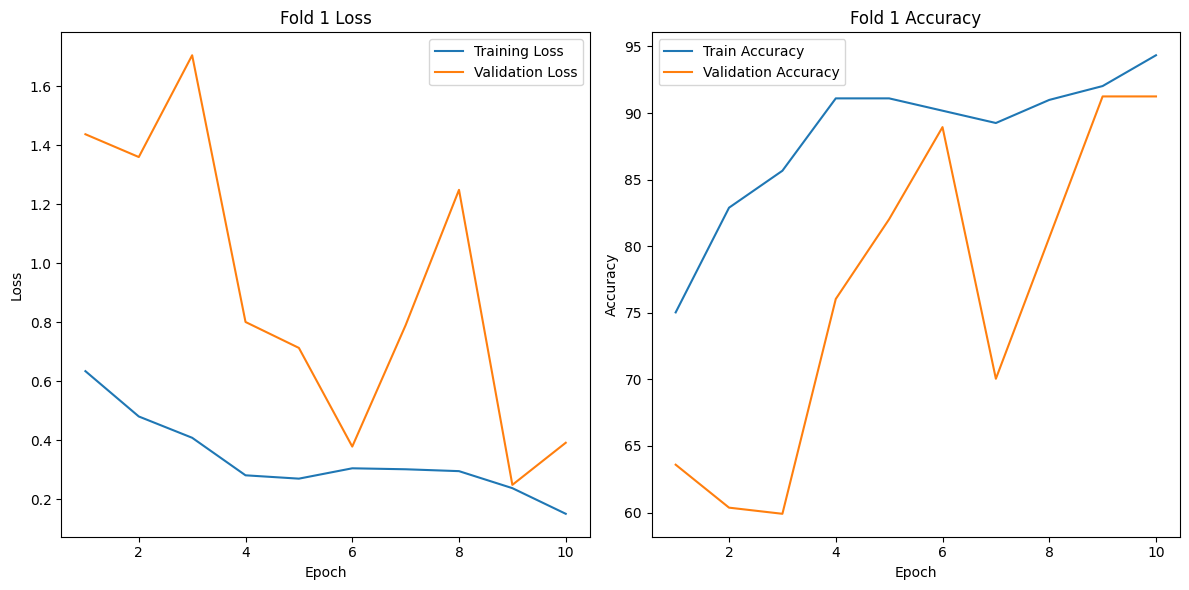



Classification Report for the Best Epoch (Epoch 9) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.89      0.95      0.92        42

    Diabetes       0.93      0.94      0.94       147

    Glaucoma       0.83      0.71      0.77        28



    accuracy                           0.91       217

   macro avg       0.88      0.87      0.87       217

weighted avg       0.91      0.91      0.91       217





Fold 2/5

Epoch 1:

  -- Training dataset. Classified 649 out of 865 images to correct labels (75.029%). Epoch loss: 0.663

   - Validation dataset. Classified 35 out of 217 images to correct labels (16.129%). Epoch loss: 45.349

Epoch 2:

  -- Training dataset. Classified 745 out of 865 images to correct labels (86.127%). Epoch loss: 0.439

   - Validation dataset. Classified 141 out of 217 images to correct labels (64.977%). Epoch loss: 1.530

Epoch 3:

  -- Training dataset. Classified 748 out of 865 images to correct labels (86.474%

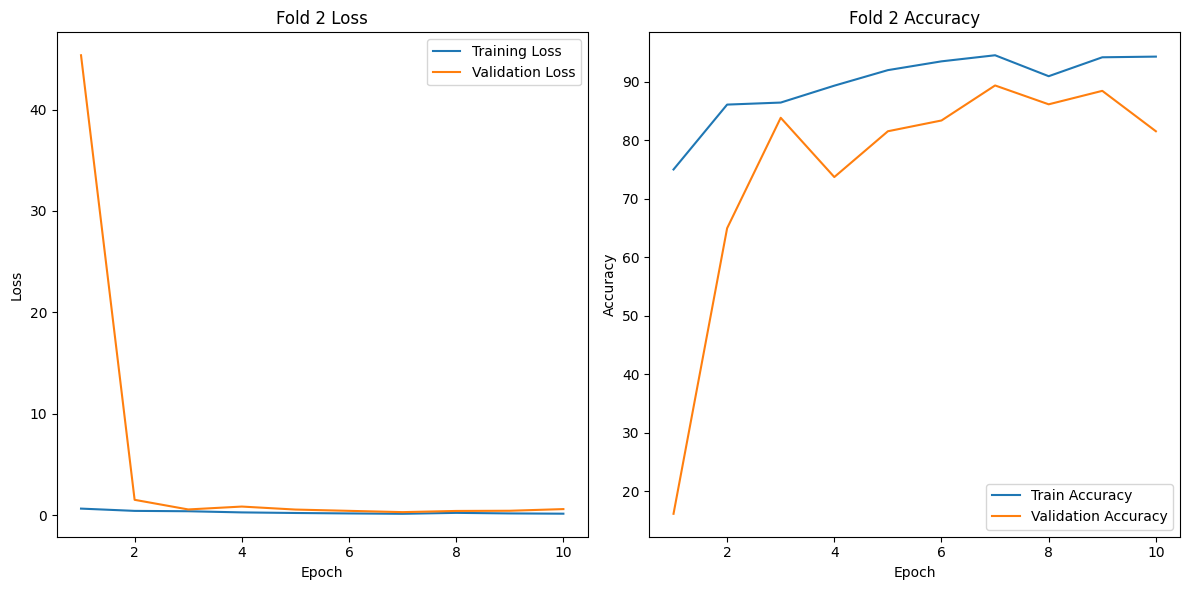



Classification Report for the Best Epoch (Epoch 7) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.91      0.89      0.90        35

    Diabetes       0.93      0.92      0.93       154

    Glaucoma       0.70      0.75      0.72        28



    accuracy                           0.89       217

   macro avg       0.85      0.85      0.85       217

weighted avg       0.90      0.89      0.89       217





Fold 3/5

Epoch 1:

  -- Training dataset. Classified 684 out of 866 images to correct labels (78.984%). Epoch loss: 0.552

   - Validation dataset. Classified 76 out of 216 images to correct labels (35.185%). Epoch loss: 12.798

Epoch 2:

  -- Training dataset. Classified 756 out of 866 images to correct labels (87.298%). Epoch loss: 0.375

   - Validation dataset. Classified 120 out of 216 images to correct labels (55.556%). Epoch loss: 1.744

Epoch 3:

  -- Training dataset. Classified 746 out of 866 images to correct labels (86.143%

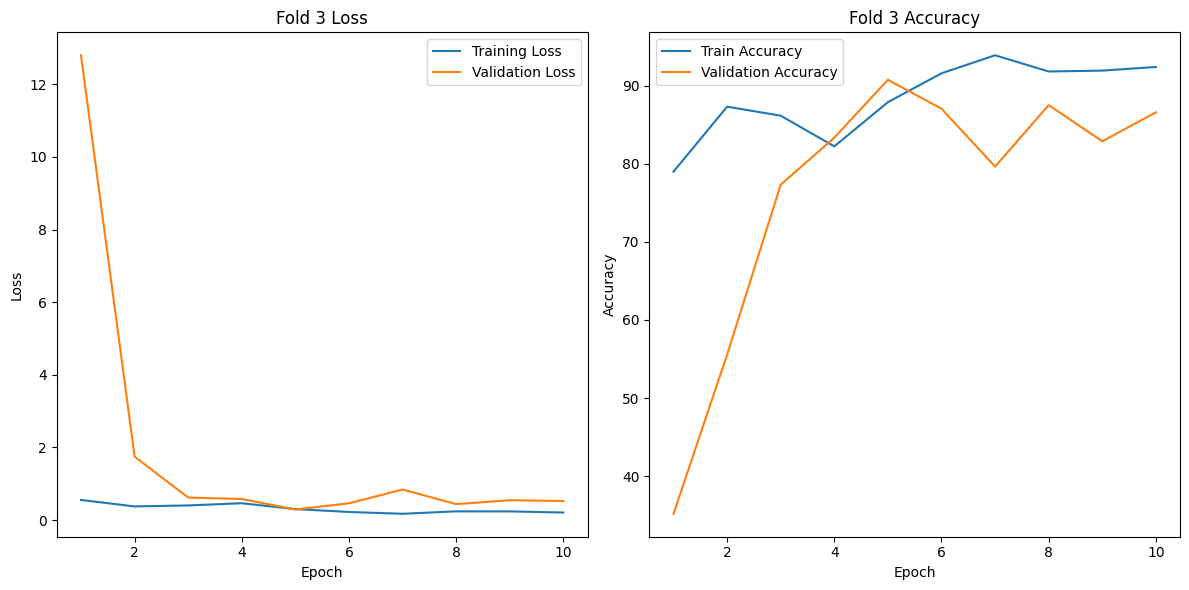



Classification Report for the Best Epoch (Epoch 5) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.94      0.96      0.95        51

    Diabetes       0.91      0.95      0.93       132

    Glaucoma       0.81      0.64      0.71        33



    accuracy                           0.91       216

   macro avg       0.89      0.85      0.87       216

weighted avg       0.90      0.91      0.90       216





Fold 4/5

Epoch 1:

  -- Training dataset. Classified 657 out of 866 images to correct labels (75.866%). Epoch loss: 0.629

   - Validation dataset. Classified 159 out of 216 images to correct labels (73.611%). Epoch loss: 6.147

Epoch 2:

  -- Training dataset. Classified 703 out of 866 images to correct labels (81.178%). Epoch loss: 0.502

   - Validation dataset. Classified 180 out of 216 images to correct labels (83.333%). Epoch loss: 0.459

Epoch 3:

  -- Training dataset. Classified 749 out of 866 images to correct labels (86.490%

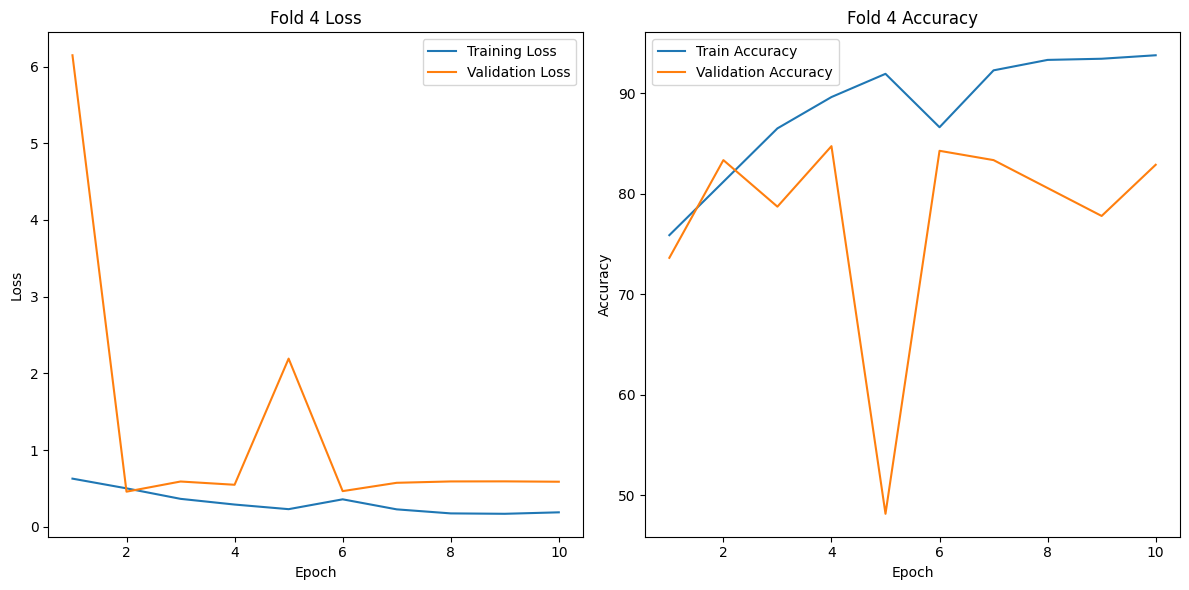



Classification Report for the Best Epoch (Epoch 4) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.91      0.89      0.90        46

    Diabetes       0.90      0.91      0.90       132

    Glaucoma       0.59      0.58      0.59        38



    accuracy                           0.85       216

   macro avg       0.80      0.79      0.80       216

weighted avg       0.85      0.85      0.85       216





Fold 5/5

Epoch 1:

  -- Training dataset. Classified 674 out of 866 images to correct labels (77.829%). Epoch loss: 0.637

   - Validation dataset. Classified 155 out of 216 images to correct labels (71.759%). Epoch loss: 1.853

Epoch 2:

  -- Training dataset. Classified 708 out of 866 images to correct labels (81.755%). Epoch loss: 0.462

   - Validation dataset. Classified 179 out of 216 images to correct labels (82.870%). Epoch loss: 0.492

Epoch 3:

  -- Training dataset. Classified 765 out of 866 images to correct labels (88.337%

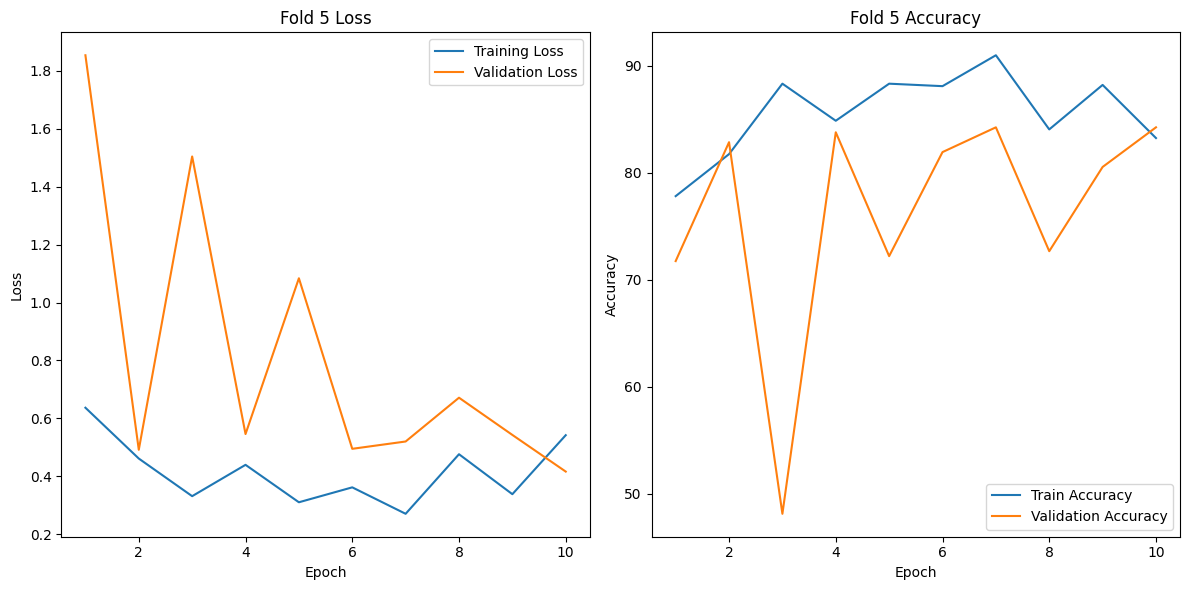



Classification Report for the Best Epoch (Epoch 7) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.74      0.86      0.79        36

    Diabetes       0.93      0.89      0.91       147

    Glaucoma       0.61      0.61      0.61        33



    accuracy                           0.84       216

   macro avg       0.76      0.79      0.77       216

weighted avg       0.85      0.84      0.84       216





Best overall model from fold 1 with validation accuracy: 91.24%



Confusion Matrix for the best model (Fold 1):


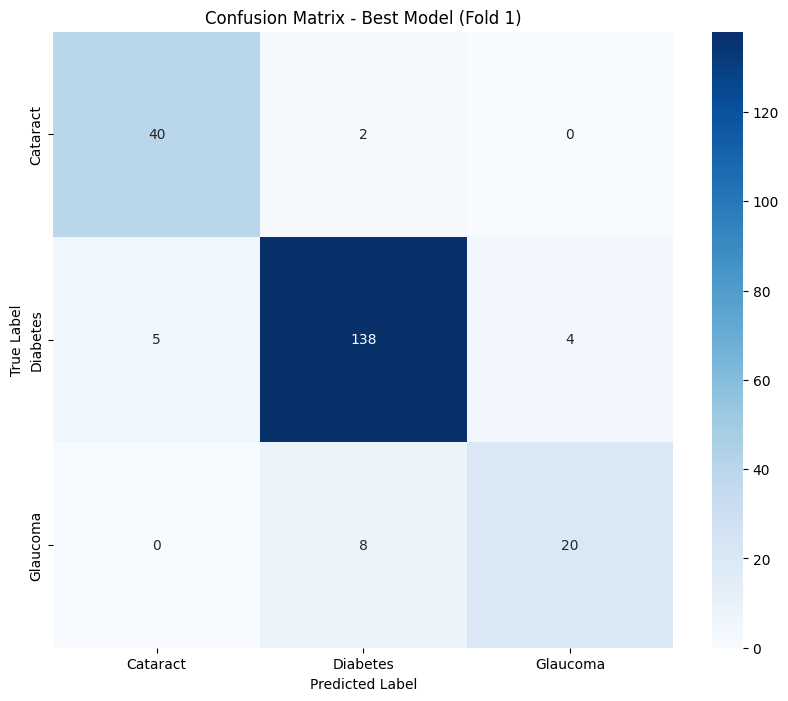



Classification Report for the best model (Fold 1):

              precision    recall  f1-score   support



    Cataract       0.89      0.95      0.92        42

    Diabetes       0.93      0.94      0.94       147

    Glaucoma       0.83      0.71      0.77        28



    accuracy                           0.91       217

   macro avg       0.88      0.87      0.87       217

weighted avg       0.91      0.91      0.91       217





Training and evaluation finished.


In [25]:
# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 224x224
    transforms.ToTensor(),  # Converting images to tensors
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)  

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10  
k = 5  

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k) 

## 4.3 ResNet with Image size (448 x 448) pixels



Fold 1/5

Epoch 1:

  -- Training dataset. Classified 649 out of 865 images to correct labels (75.029%). Epoch loss: 0.661

   - Validation dataset. Classified 137 out of 217 images to correct labels (63.134%). Epoch loss: 0.787

Epoch 2:

  -- Training dataset. Classified 711 out of 865 images to correct labels (82.197%). Epoch loss: 0.475

   - Validation dataset. Classified 78 out of 217 images to correct labels (35.945%). Epoch loss: 5.169

Epoch 3:

  -- Training dataset. Classified 709 out of 865 images to correct labels (81.965%). Epoch loss: 0.461

   - Validation dataset. Classified 169 out of 217 images to correct labels (77.880%). Epoch loss: 0.634

Epoch 4:

  -- Training dataset. Classified 735 out of 865 images to correct labels (84.971%). Epoch loss: 0.396

   - Validation dataset. Classified 184 out of 217 images to correct labels (84.793%). Epoch loss: 0.467

Epoch 5:

  -- Training dataset. Classified 741 out of 865 images to correct labels (85.665%). Epoch loss: 0.

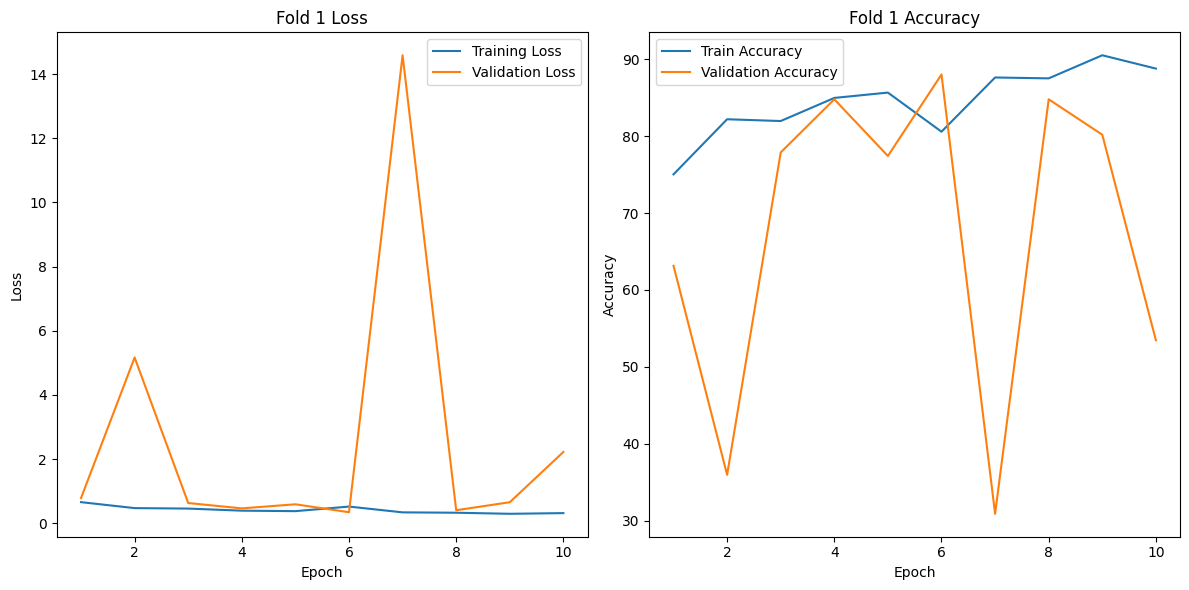



Classification Report for the Best Epoch (Epoch 6) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.83      0.93      0.88        42

    Diabetes       0.92      0.95      0.93       147

    Glaucoma       0.71      0.43      0.53        28



    accuracy                           0.88       217

   macro avg       0.82      0.77      0.78       217

weighted avg       0.87      0.88      0.87       217





Fold 2/5

Epoch 1:

  -- Training dataset. Classified 644 out of 865 images to correct labels (74.451%). Epoch loss: 0.685

   - Validation dataset. Classified 185 out of 217 images to correct labels (85.253%). Epoch loss: 0.473

Epoch 2:

  -- Training dataset. Classified 703 out of 865 images to correct labels (81.272%). Epoch loss: 0.534

   - Validation dataset. Classified 176 out of 217 images to correct labels (81.106%). Epoch loss: 0.450

Epoch 3:

  -- Training dataset. Classified 734 out of 865 images to correct labels (84.855%

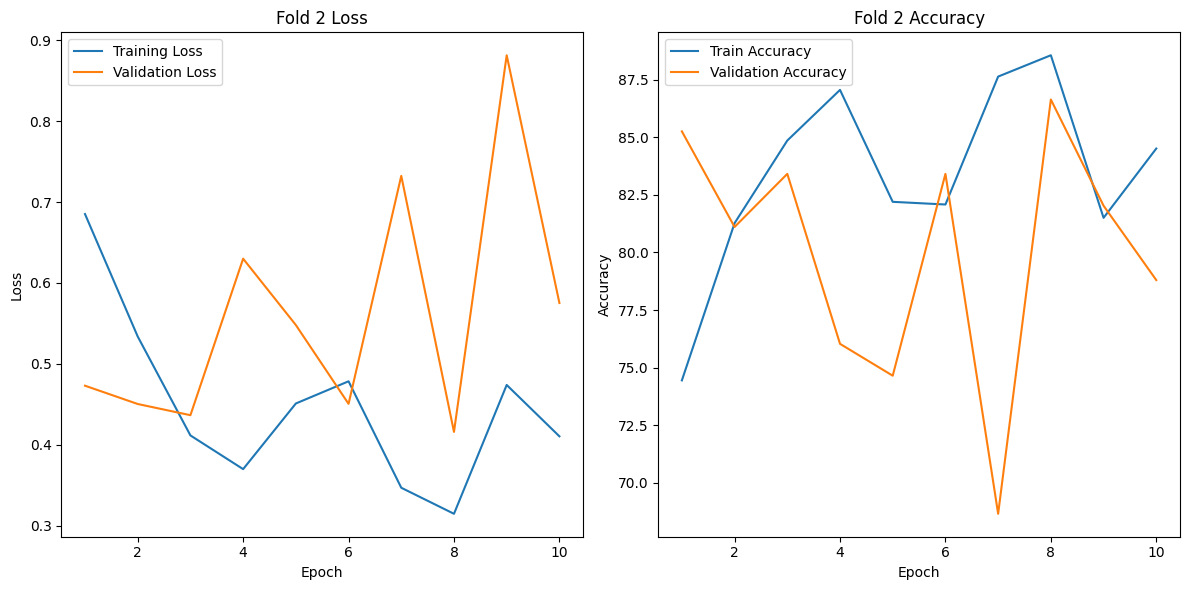



Classification Report for the Best Epoch (Epoch 8) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.94      0.86      0.90        35

    Diabetes       0.88      0.95      0.92       154

    Glaucoma       0.60      0.43      0.50        28



    accuracy                           0.87       217

   macro avg       0.81      0.74      0.77       217

weighted avg       0.86      0.87      0.86       217





Fold 3/5

Epoch 1:

  -- Training dataset. Classified 649 out of 866 images to correct labels (74.942%). Epoch loss: 0.615

   - Validation dataset. Classified 85 out of 216 images to correct labels (39.352%). Epoch loss: 10.695

Epoch 2:

  -- Training dataset. Classified 720 out of 866 images to correct labels (83.141%). Epoch loss: 0.433

   - Validation dataset. Classified 141 out of 216 images to correct labels (65.278%). Epoch loss: 0.854

Epoch 3:

  -- Training dataset. Classified 738 out of 866 images to correct labels (85.219%

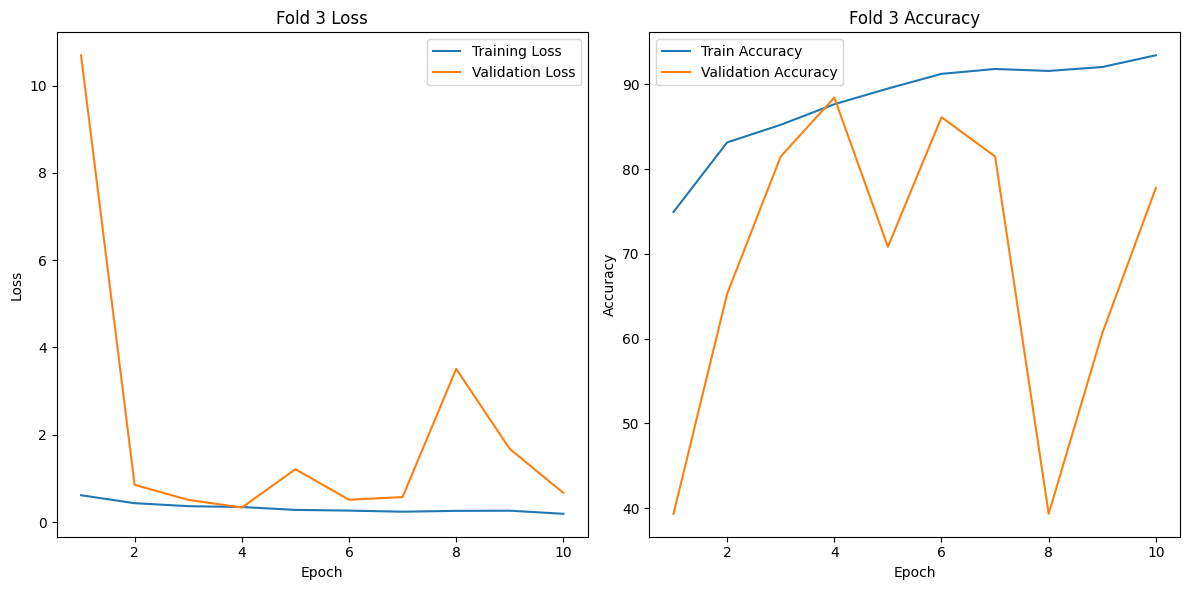



Classification Report for the Best Epoch (Epoch 4) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.88      0.96      0.92        51

    Diabetes       0.92      0.92      0.92       132

    Glaucoma       0.72      0.64      0.68        33



    accuracy                           0.88       216

   macro avg       0.84      0.84      0.84       216

weighted avg       0.88      0.88      0.88       216





Fold 4/5

Epoch 1:

  -- Training dataset. Classified 633 out of 866 images to correct labels (73.095%). Epoch loss: 0.672

   - Validation dataset. Classified 169 out of 216 images to correct labels (78.241%). Epoch loss: 1.821

Epoch 2:

  -- Training dataset. Classified 713 out of 866 images to correct labels (82.333%). Epoch loss: 0.481

   - Validation dataset. Classified 138 out of 216 images to correct labels (63.889%). Epoch loss: 0.861

Epoch 3:

  -- Training dataset. Classified 722 out of 866 images to correct labels (83.372%

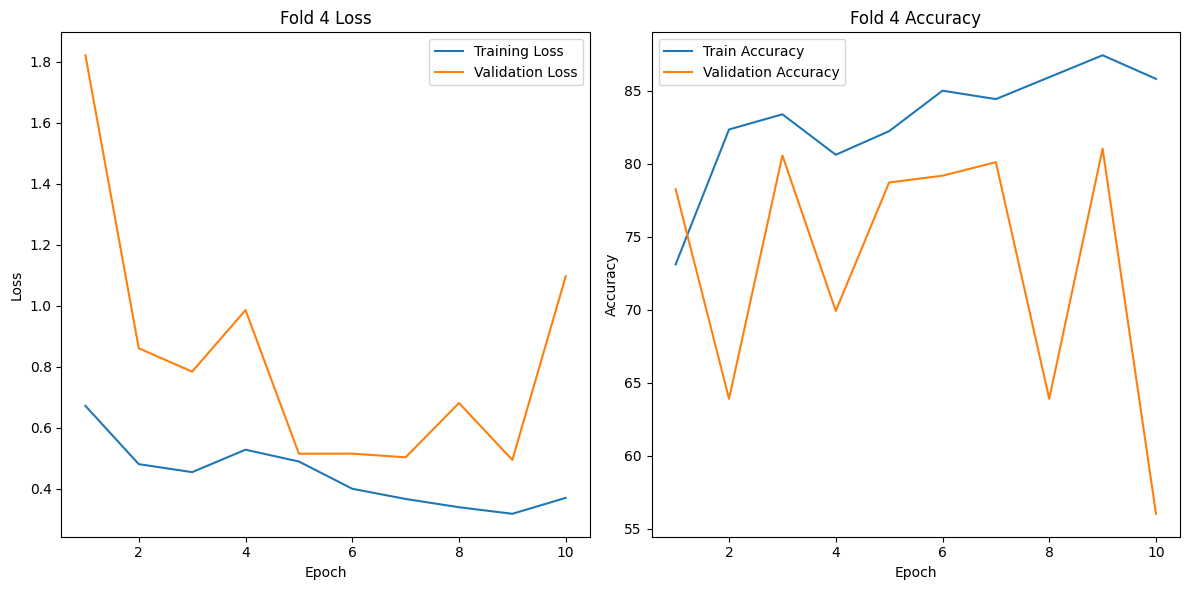



Classification Report for the Best Epoch (Epoch 9) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.84      0.91      0.87        46

    Diabetes       0.82      0.95      0.88       132

    Glaucoma       0.62      0.21      0.31        38



    accuracy                           0.81       216

   macro avg       0.76      0.69      0.69       216

weighted avg       0.79      0.81      0.78       216





Fold 5/5

Epoch 1:

  -- Training dataset. Classified 658 out of 866 images to correct labels (75.982%). Epoch loss: 0.630

   - Validation dataset. Classified 33 out of 216 images to correct labels (15.278%). Epoch loss: 36.759

Epoch 2:

  -- Training dataset. Classified 723 out of 866 images to correct labels (83.487%). Epoch loss: 0.451

   - Validation dataset. Classified 140 out of 216 images to correct labels (64.815%). Epoch loss: 1.063

Epoch 3:

  -- Training dataset. Classified 721 out of 866 images to correct labels (83.256%

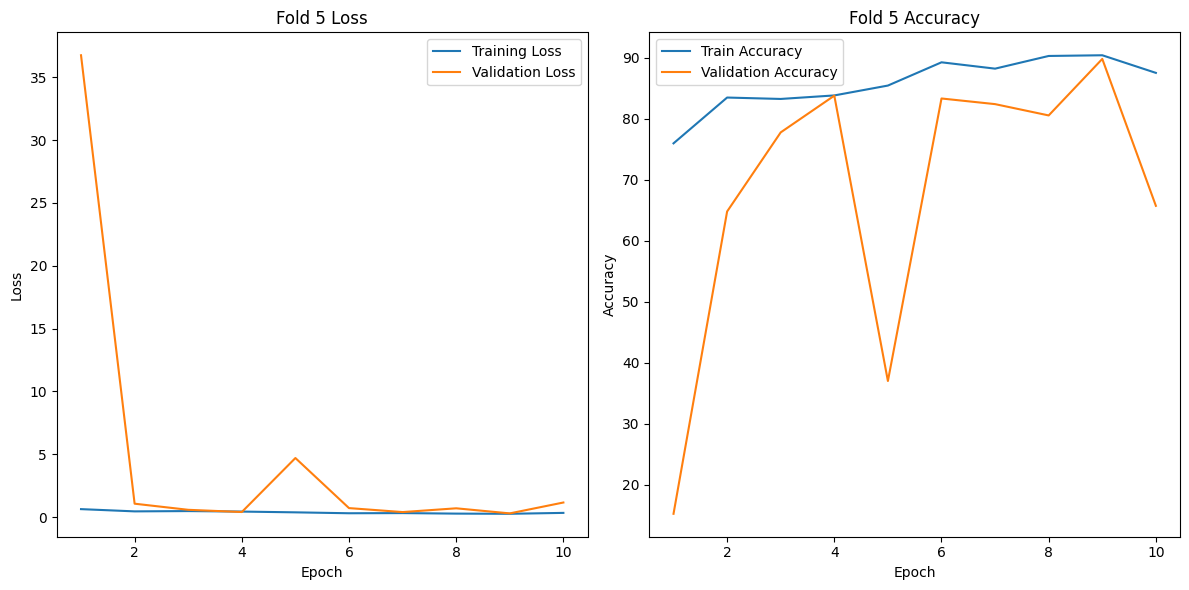



Classification Report for the Best Epoch (Epoch 9) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.95      0.97      0.96        36

    Diabetes       0.92      0.94      0.93       147

    Glaucoma       0.72      0.64      0.68        33



    accuracy                           0.90       216

   macro avg       0.86      0.85      0.86       216

weighted avg       0.89      0.90      0.90       216





Best overall model from fold 5 with validation accuracy: 89.81%



Confusion Matrix for the best model (Fold 5):


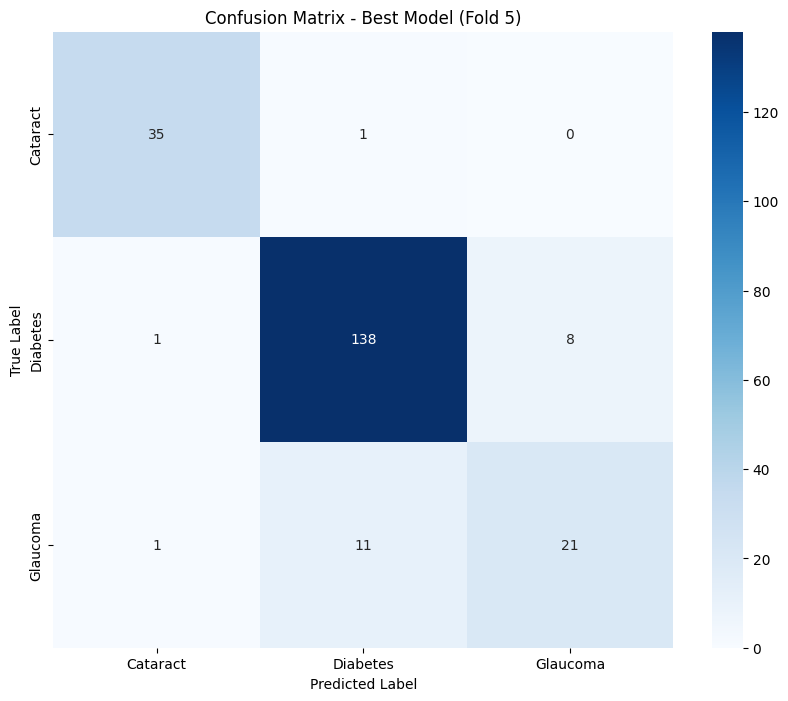



Classification Report for the best model (Fold 5):

              precision    recall  f1-score   support



    Cataract       0.95      0.97      0.96        36

    Diabetes       0.92      0.94      0.93       147

    Glaucoma       0.72      0.64      0.68        33



    accuracy                           0.90       216

   macro avg       0.86      0.85      0.86       216

weighted avg       0.89      0.90      0.90       216





Training and evaluation finished.


In [26]:
# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((448, 448)),  
    transforms.ToTensor(), 
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)  

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10  
k = 5 

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k)  